# Title: An analysis to predict customer churn & improve customer retention

## Overview

The backbone of every business are those who patronize it, in this case customers. They are the ones that determine the value of products or services that businesses offer. Without the customer, there really is no business. Businesses strive to get new customers all the time but are also concerned with their existing customers coming back. This has made customer churn a very important metric for any serious company or business.
Customer churn is the loss of any customer for any reason possible. In this analysis we will be taking a look at the possible reasons for the loss of customers in a telecommunications company. We also aim to build predictive models that will identify customers that are likely to churn and the factors that lead to them doing so to enable the company to take proactive steps to keep customers.

## Setup

### Import Necessary Libraries

In [1]:
# Retrieving Data from Database
import pyodbc
from dotenv import dotenv_values

# Data handling
import pandas as pd
import numpy as np

#  Visualisation 
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Feature Processing 
from sklearn import preprocessing
from sklearn.impute import SimpleImputer

# Other packages
import os
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

import pickle
import shutil

import random
from lime import lime_tabular
import shap
import matplotlib.gridspec as gs

#display all columns and rows 
pd.set_option('display.max_columns', None)

### Data Retrieval

The data was retrieved from a SQL database, a One Drive folder and github repository and stored on a local machine.

##### SQL Database Retrieval

In [ ]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')
# Get the values for the credentials you set in the '.env' file
database = environment_variables.get("DATABASE")
server = environment_variables.get("SERVER")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")
table_name = environment_variables.get("TABLE_NAME")
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

In [ ]:
connection = pyodbc.connect(connection_string)

In [ ]:
query = "Select * from dbo.LP2_Telco_churn_first_3000"
data = pd.read_sql(query, connection)

data.to_csv("Raw Data/Telco-churn-first-3000.csv")

### Data Loading

In [194]:
# Load 1st dataset (training data)
df1= pd.read_csv('Raw Data/Telco-churn-first-3000.csv')

# Load 2nd dataset (training data) 
df2 = pd.read_csv('Raw Data/LP2_Telco-churn-last-2000.csv')

# Load 2nd dataset (test data)
test = pd.read_excel('Raw Data/Telco-churn-second-2000.xlsx')

The 1st and 2nd datasets are to be concatenated to create a single dataset that would be used to train the models

In [195]:
df1.shape

(3000, 22)

In [196]:
# Concatenate datasets
train = pd.concat([df1, df2])

In [197]:
train.head()

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0.0,7590-VHVEG,Female,0,True,False,1,False,NaN,DSL,False,True,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.85,False
1,1.0,5575-GNVDE,Male,0,False,False,34,True,False,DSL,True,False,True,False,False,False,One year,False,Mailed check,56.950001,1889.5,False
2,2.0,3668-QPYBK,Male,0,False,False,2,True,False,DSL,True,True,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,3.0,7795-CFOCW,Male,0,False,False,45,False,NaN,DSL,True,False,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.75,False
4,4.0,9237-HQITU,Female,0,False,False,2,True,False,Fiber optic,False,False,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [198]:
# Find the number of rows and columns
train.shape

(5043, 22)

In [199]:
# Get info on whole dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5043 entries, 0 to 2042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        3000 non-null   float64
 1   customerID        5043 non-null   object 
 2   gender            5043 non-null   object 
 3   SeniorCitizen     5043 non-null   int64  
 4   Partner           5043 non-null   object 
 5   Dependents        5043 non-null   object 
 6   tenure            5043 non-null   int64  
 7   PhoneService      5043 non-null   object 
 8   MultipleLines     4774 non-null   object 
 9   InternetService   5043 non-null   object 
 10  OnlineSecurity    4392 non-null   object 
 11  OnlineBackup      4392 non-null   object 
 12  DeviceProtection  4392 non-null   object 
 13  TechSupport       4392 non-null   object 
 14  StreamingTV       4392 non-null   object 
 15  StreamingMovies   4392 non-null   object 
 16  Contract          5043 non-null   object 
 17  

The following describes the columns present in the data.

customerID -- Customer's unique ID

Gender -- Whether the customer is a male or a female

SeniorCitizen -- Whether a customer is a senior citizen or not

Partner -- Whether the customer has a partner or not (Yes, No)

Dependents -- Whether the customer has dependents or not (Yes, No)

Tenure -- Number of months the customer has stayed with the company

Phone Service -- Whether the customer has a phone service or not (Yes, No)

MultipleLines -- Whether the customer has multiple lines or not

InternetService -- Customer's internet service provider (DSL, Fiber Optic, No)

OnlineSecurity -- Whether the customer has online security or not (Yes, No, No Internet)

OnlineBackup -- Whether the customer has online backup or not (Yes, No, No Internet)

DeviceProtection -- Whether the customer has device protection or not (Yes, No, No internet service)

TechSupport -- Whether the customer has tech support or not (Yes, No, No internet)

StreamingTV -- Whether the customer has streaming TV or not (Yes, No, No internet service)

StreamingMovies -- Whether the customer has streaming movies or not (Yes, No, No Internet service)

Contract -- The contract term of the customer (Month-to-Month, One year, Two year)

PaperlessBilling -- Whether the customer has paperless billing or not (Yes, No)

Payment Method -- The customer's payment method (Electronic check, mailed check, Bank transfer(automatic), Credit card(automatic))

MonthlyCharges -- The amount charged to the customer monthly

TotalCharges -- The total amount charged to the customer

Churn -- Whether the customer churned or not (Yes or No)

In [200]:
# Drop Unnamed: 0 column
train= train.drop('Unnamed: 0', axis =1)

In [201]:
#get info on the whole dataset

train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   int64  
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-null   object 
 17  

In [202]:
# Check columns 
train.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [203]:
# Get a description of numerical features
train.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,5043.000000,5043.000000,5043.000000
mean,0.162403,32.576641,65.090214
std,0.368857,24.529807,30.068133
min,0.000000,0.000000,18.400000
25%,0.000000,9.000000,35.775000
50%,0.000000,29.000000,70.550003
75%,0.000000,56.000000,90.050003
max,1.000000,72.000000,118.650002


In [204]:
# Get summary statistics for all columns in churn_data
summary_stats = train.describe(include=['O'])
summary_stats

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
count,5043,5043,5043,5043,5043,4774,5043,4392,4392,4392,4392,4392,4392,5043,5043,5043,5038.000000,5042
unique,5043,2,4,4,4,5,3,5,5,5,5,5,5,3,4,4,4884.000000,4
top,7590-VHVEG,Male,False,False,True,False,Fiber optic,False,False,False,False,False,True,Month-to-month,True,Electronic check,20.200001,False
freq,1,2559,1538,2070,2731,1437,2248,1478,1320,1296,1476,1190,1199,2744,1776,1700,5.000000,2219


## Questions 

1. Does the gender of the customer affect the churn rate?
2. Are senior citizens more reluctant to churn than those who are not senior citizens?
3. How does the amount spent per month affect churn?
4. How important is tech support in customer retention?
5. Does internet service subscription affect the payment method used?
6. What tenure range is very likely to churn? 
7. Does having a partner and dependents influence churn rate positively or negatively?
8. Do customers with both phone service and internet service churn more than customers with one of the two?








## Hypothesis 

###### NULL : Customers on the yearly contracts are not likely to churn
###### ALTERNATE : Customers on the yearly contracts are more likely to churn

## Data Cleaning 

### Training Dataset

#### Missing Values

In [205]:
# Check for null values
train.isna().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 1
dtype: int64

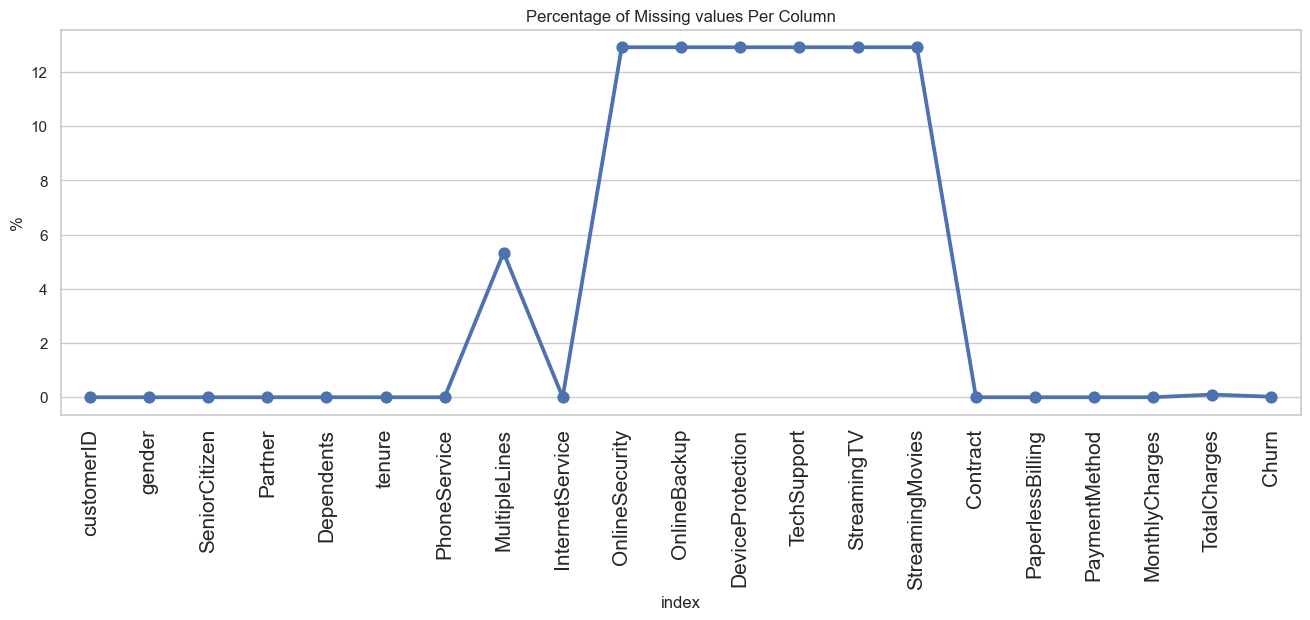

In [206]:
# Plot to show missing values per column

null_values= pd.DataFrame((train.isnull().sum())*100/train.shape[0]).reset_index()
plt.figure(figsize=(16,5))
ax = sns.pointplot(x='index', y=0,data=null_values)
plt.xticks(rotation =90,fontsize =15)
plt.title("Percentage of Missing values Per Column")
plt.ylabel("%")
plt.show()


For missing/null values, we will be filling them with the most frequent values


In [207]:
# Fill missing values with the most frequent values in the dataset
train = train.fillna(train.mode().iloc[0])

In [208]:
# Check for null values
train.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

#### Duplicates


#### Check for duplicates 

In [209]:
# Find sum of duplicates
train.duplicated().sum()

0

In [210]:
# Drop duplicates 
train = train.drop_duplicates()

### Test Dataset

In [211]:
test.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8
2,9513-DXHDA,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55
3,2640-PMGFL,Male,0,No,Yes,27,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55
4,3801-HMYNL,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15


In [212]:
test.shape

(2000, 20)

In [213]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2000 non-null   object 
 1   gender            2000 non-null   object 
 2   SeniorCitizen     2000 non-null   int64  
 3   Partner           2000 non-null   object 
 4   Dependents        2000 non-null   object 
 5   tenure            2000 non-null   int64  
 6   PhoneService      2000 non-null   object 
 7   MultipleLines     2000 non-null   object 
 8   InternetService   2000 non-null   object 
 9   OnlineSecurity    2000 non-null   object 
 10  OnlineBackup      2000 non-null   object 
 11  DeviceProtection  2000 non-null   object 
 12  TechSupport       2000 non-null   object 
 13  StreamingTV       2000 non-null   object 
 14  StreamingMovies   2000 non-null   object 
 15  Contract          2000 non-null   object 
 16  PaperlessBilling  2000 non-null   object 


#### Missing Values

In [214]:
test.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [215]:
test.duplicated().sum()

0

## EDA

#### Training Dataset

In this section we explore the dataset to get deeper insights

##### Customer ID Feature

In [216]:
train['customerID']

0       7590-VHVEG
1       5575-GNVDE
2       3668-QPYBK
3       7795-CFOCW
4       9237-HQITU
           ...    
2038    6840-RESVB
2039    2234-XADUH
2040    4801-JZAZL
2041    8361-LTMKD
2042    3186-AJIEK
Name: customerID, Length: 5043, dtype: object

Customer ID will not be needed for analysis and modeling so can be dropped

In [217]:
train = train.drop('customerID', axis=1)

##### Gender column

In [218]:
train['gender'].unique()

array(['Female', 'Male'], dtype=object)

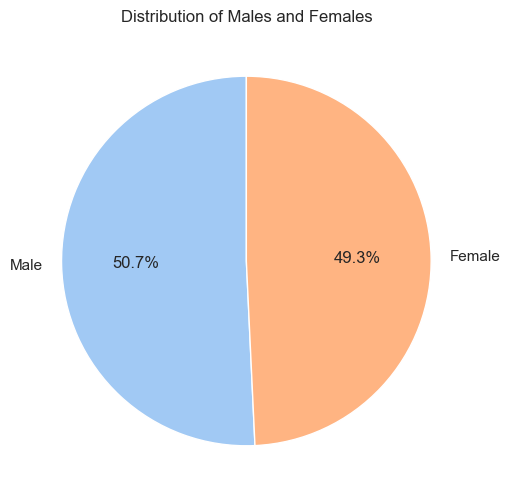

In [219]:
# Set the style of the plot
sns.set(style="whitegrid")

# Create a pie chart
plt.figure(figsize=(8, 6))  

# Count the occurrences of each gender
gender_counts = train['gender'].value_counts()

# Plot the pie chart
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))

# Add a title
plt.title("Distribution of Males and Females")

# Show the plot
plt.show()


##### Senior Citizen column

In [220]:
train['SeniorCitizen'].unique()

array([0, 1], dtype=int64)

In [221]:
# Change all entries under Senior Citizen to Yes or No
replacement_values = {0: 'No', 1: 'Yes'}

train['SeniorCitizen'] = train['SeniorCitizen'].replace(replacement_values)

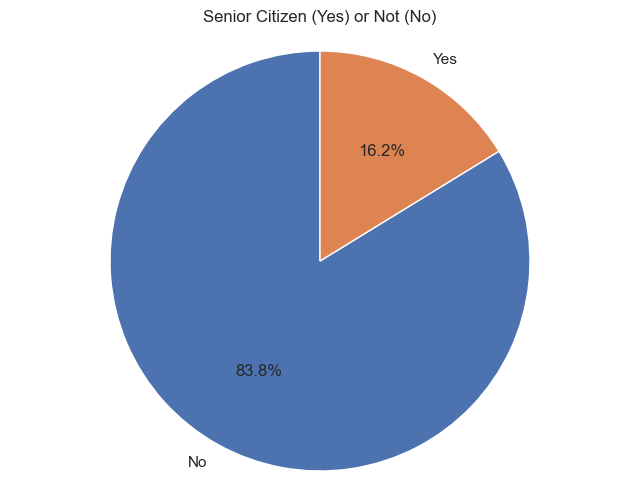

In [222]:
# Set the style of the plot
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))

# Calculate the count of each category
counts = train['SeniorCitizen'].value_counts()

# Create the pie chart
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title("Senior Citizen (Yes) or Not (No)")

# Show the plot
plt.show()

##### Partner Column

In [223]:
train['Partner'].unique()

array([True, False, 'No', 'Yes'], dtype=object)

In [224]:
# Change all entries under Partner to 'Yes' or 'No'
replacement_values = {False: 'No', True: 'Yes'}

train['Partner'] = train['Partner'].replace(replacement_values)

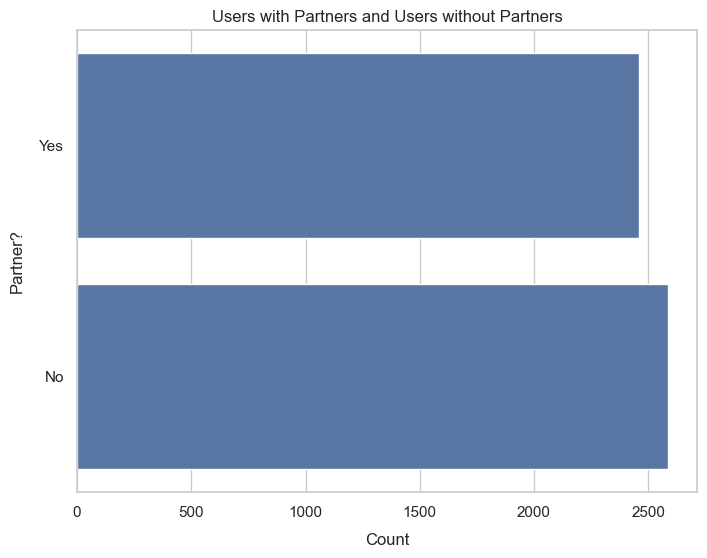

In [225]:
# Set the style of the plot
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))  
# Create the horizontal bar plot
sns.countplot(y='Partner', data=train)
plt.xlabel("Count", labelpad=10)
plt.ylabel("Partner?", labelpad=10)
plt.title("Users with Partners and Users without Partners", y=1)

# Show the plot
plt.show()

##### Dependents

In [226]:
train['Dependents'].unique()

array([False, True, 'No', 'Yes'], dtype=object)

In [227]:
# Change all entries under Dependednts to 'Yes' or 'No'
replacement_values = {False: 'No', True: 'Yes'}

train['Dependents'] = train['Dependents'].replace(replacement_values)

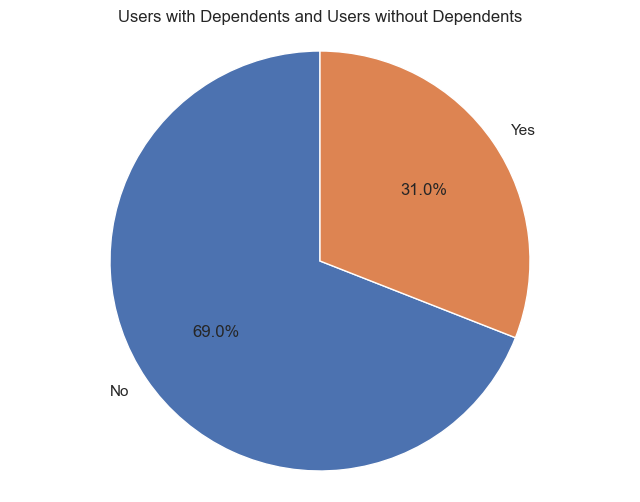

In [228]:
# Set the style of the plot
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))

# Calculate the count of each category
counts = train['Dependents'].value_counts()

# Create the pie chart
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title("Users with Dependents and Users without Dependents")

# Show the plot
plt.show()

##### Tenure

In [229]:
train['tenure'].unique()

array([ 1, 34,  2, 45,  8, 22, 10, 28, 62, 13, 16, 58, 49, 25, 69, 52, 71,
       21, 12, 30, 47, 72, 17, 27,  5, 46, 11, 70, 63, 43, 15, 60, 18, 66,
        9,  3, 31, 50, 64, 56,  7, 42, 35, 48, 29, 65, 38, 68, 32, 55, 37,
       36, 41,  6,  4, 33, 67, 23, 57, 61, 14, 20, 53, 40, 59, 24, 44, 19,
       54, 51, 26,  0, 39], dtype=int64)

In [230]:
train['tenure'].max()

72

In [231]:
train['tenure'].min()

0

In [232]:
# Group the tenure in bins of 12 months
labels = ["{0} - {1}".format(i, i + 11) for i in range(1, 72, 12)]

train['tenure_range'] = pd.cut(train.tenure, range(1, 80, 12), right=False, labels=labels)

# Counts of each tenure range
train['tenure_range'].value_counts()

tenure_range
1 - 12     1534
61 - 72    1017
13 - 24     732
25 - 36     603
49 - 60     590
37 - 48     559
Name: count, dtype: int64

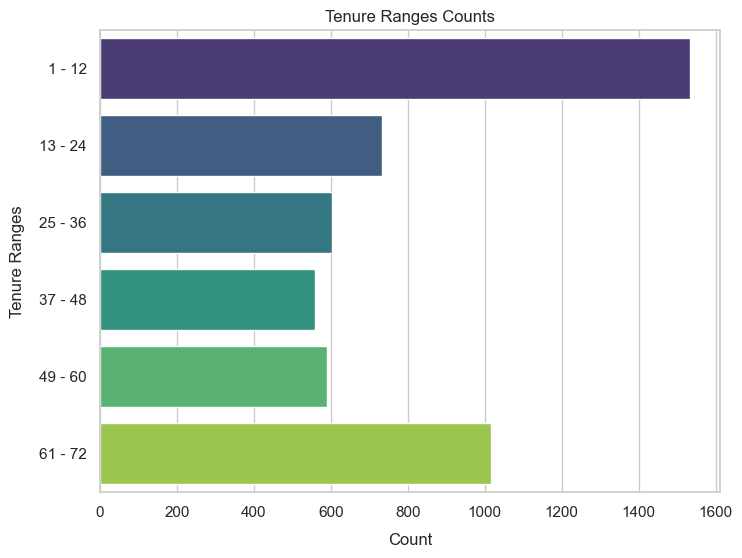

In [233]:
# Set the style of the plot
sns.set(style="whitegrid")

# Create a count plot for tenure ranges
plt.figure(figsize=(8, 6))
sns.barplot(x='count', y='tenure_range', data=tenure_counts, palette="viridis")

# Labeling and title
plt.xlabel("Count", labelpad=10)
plt.ylabel("Tenure Ranges", labelpad=10)
plt.title("Tenure Ranges Counts", y=1)

# Show the plot
plt.show()


##### PhoneService

In [234]:
train['PhoneService'].unique()

array([False, True, 'Yes', 'No'], dtype=object)

In [235]:
# Change all entries under PhoneService to 'Yes' or 'No'
replacement_values = {True: 'Yes', False:'No'}

train['PhoneService'] = train['PhoneService'].replace(replacement_values)

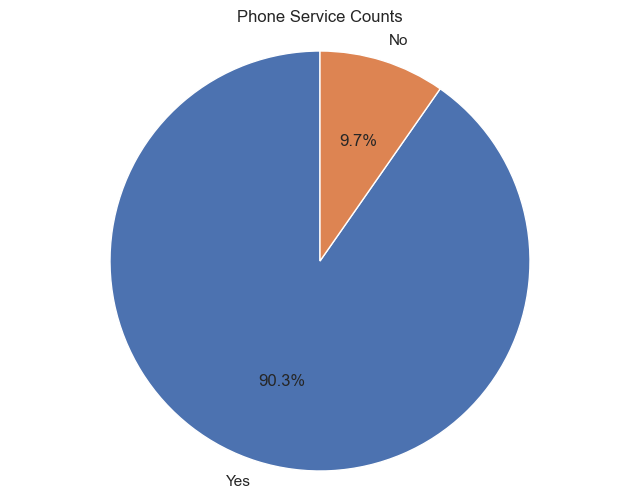

In [236]:
# Set the style of the plot
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))

# Calculate the count of each category
counts = train['PhoneService'].value_counts()

# Create the pie chart
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title("Phone Service Counts")

# Show the plot
plt.show()

##### MultipleLines

In [237]:
train['MultipleLines'].unique()

array([False, True, 'No', 'No phone service', 'Yes'], dtype=object)

In [238]:
# Change all entries under MultipleLines to 'Yes' or 'No'
replacement_values = {True: 'Yes', False:'No', 'No phone service':'No'}

train['MultipleLines'] = train['MultipleLines'].replace(replacement_values)

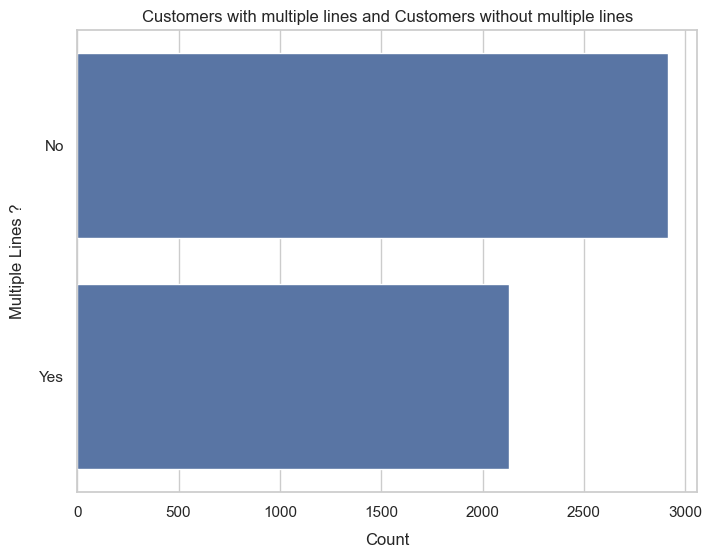

In [239]:
# Set the style of the plot
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))  
# Create the horizontal bar plot
sns.countplot(y='MultipleLines', data=train)
plt.xlabel("Count", labelpad=10)
plt.ylabel("Multiple Lines ?", labelpad=10)
plt.title("Customers with multiple lines and Customers without multiple lines", y=1)

# Show the plot
plt.show()

##### Internet Service column

In [240]:
train['InternetService'].unique()

array(['DSL', 'Fiber optic', 'No'], dtype=object)

In [241]:
# Change all entries under Internet Service to 'Yes' or 'No'
replacement_values = {'Fiber optic': 'Yes', 'DSL':'Yes'}

train['InternetService'] = train['InternetService'].replace(replacement_values)

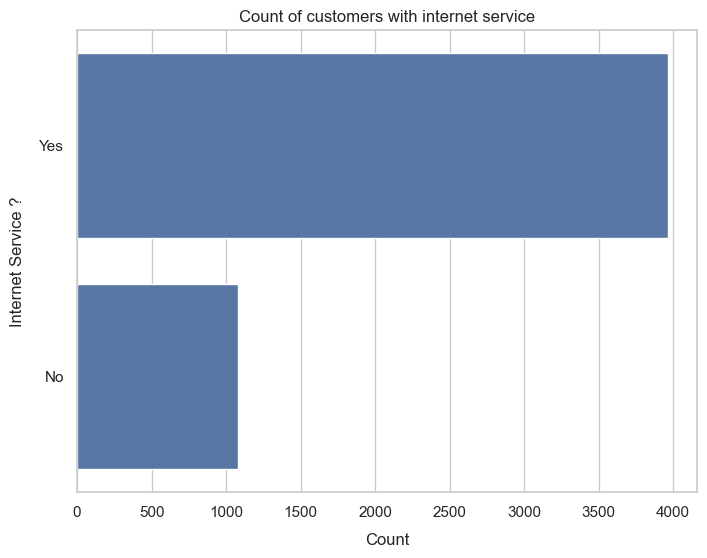

In [242]:
# Set the style of the plot
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))  
# Create the horizontal bar plot
sns.countplot(y='InternetService', data=train)
plt.xlabel("Count", labelpad=10)
plt.ylabel("Internet Service ?", labelpad=10)
plt.title("Count of customers with internet service", y=1)

# Show the plot
plt.show()

##### Online Security 

In [243]:
train['OnlineSecurity'].unique()

array([False, True, 'No', 'Yes', 'No internet service'], dtype=object)

In [244]:
# Change all entries under Online Security to 'Yes' or 'No'
replacement_values = {True: 'Yes', False:'No'}

train['OnlineSecurity'] = train['OnlineSecurity'].replace(replacement_values)

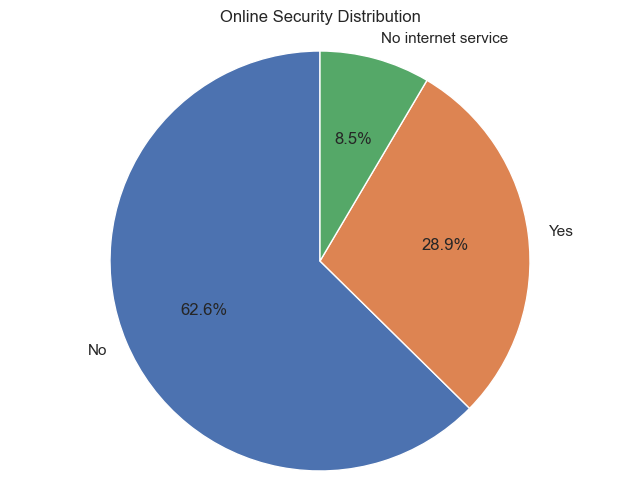

In [245]:
# Set the style of the plot
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))

# Calculate the count of each category
counts = train['OnlineSecurity'].value_counts()

# Create the pie chart
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title("Online Security Distribution")

# Show the plot
plt.show()

##### OnlineBackup

In [246]:
train['OnlineBackup'].unique()

array([True, False, 'No', 'Yes', 'No internet service'], dtype=object)

In [247]:
# Change all entries under Online Backup to 'Yes' or 'No'
replacement_values = {True: 'Yes', False:'No'}

train['OnlineBackup'] = train['OnlineBackup'].replace(replacement_values)

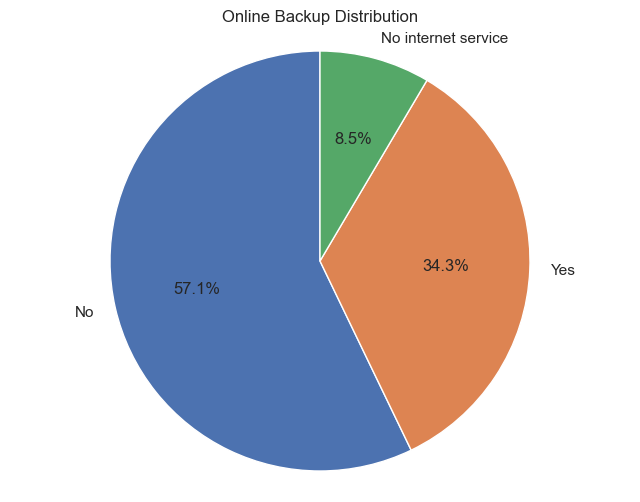

In [248]:
# Set the style of the plot
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))

# Calculate the count of each category
counts = train['OnlineBackup'].value_counts()

# Create the pie chart
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title("Online Backup Distribution")

# Show the plot
plt.show()

##### Device Protection 

In [249]:
train['DeviceProtection'].unique()

array([False, True, 'No', 'Yes', 'No internet service'], dtype=object)

In [250]:
# Change all entries under DeviceProtection to 'Yes' or 'No'
replacement_values = {True: 'Yes', False:'No'}

train['DeviceProtection'] = train['DeviceProtection'].replace(replacement_values)

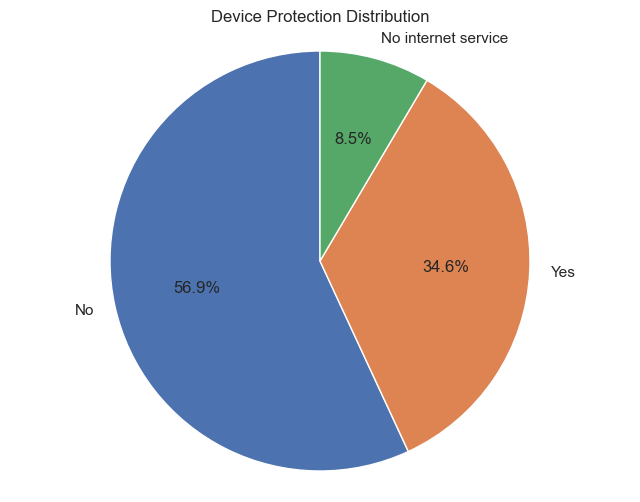

In [251]:
# Set the style of the plot
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))

# Calculate the count of each category
counts = train['DeviceProtection'].value_counts()

# Create the pie chart
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title("Device Protection Distribution")

# Show the plot
plt.show()

##### TechSupport         

In [252]:
train['TechSupport'].unique()

array([False, True, 'Yes', 'No', 'No internet service'], dtype=object)

In [253]:
# Change all entries under Tech Support to 'Yes' or 'No'
replacement_values = {True: 'Yes', False:'No'}

train['TechSupport'] = train['TechSupport'].replace(replacement_values)

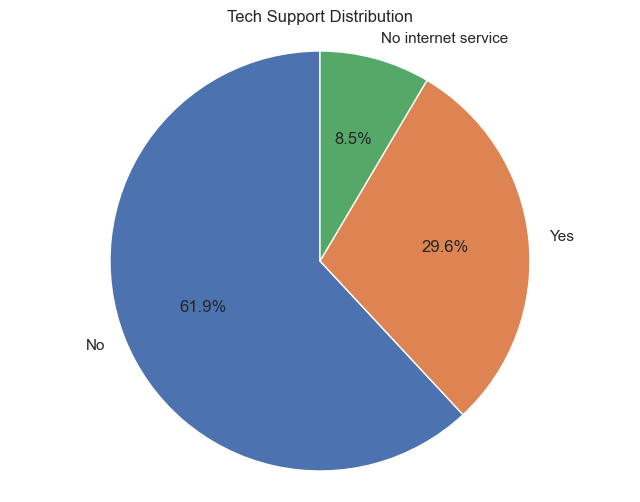

In [254]:
# Set the style of the plot
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))

# Calculate the count of each category
counts = train['TechSupport'].value_counts()

# Create the pie chart
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title("Tech Support Distribution")

# Show the plot
plt.show()

##### StreamingTV 

In [255]:
train['StreamingTV'].unique()

array([False, True, 'No', 'Yes', 'No internet service'], dtype=object)

In [256]:
# Change all entries under Streaming TV to 'Yes' or 'No'
replacement_values = {True: 'Yes', False:'No'}

train['StreamingTV'] = train['StreamingTV'].replace(replacement_values)

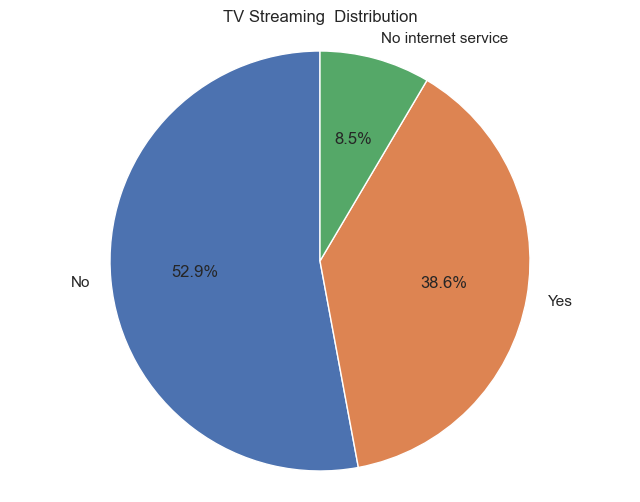

In [257]:
# Set the style of the plot
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))

# Calculate the count of each category
counts = train['StreamingTV'].value_counts()

# Create the pie chart
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title("TV Streaming  Distribution")

# Show the plot
plt.show()

##### StreamingMovies

In [258]:
train['StreamingMovies'].unique()

array([False, True, 'No', 'Yes', 'No internet service'], dtype=object)

In [259]:
# Change all entries under Streaming Movies to 'Yes' or 'No'
replacement_values = {True: 'Yes', False:'No'}

train['StreamingMovies'] = train['StreamingMovies'].replace(replacement_values)

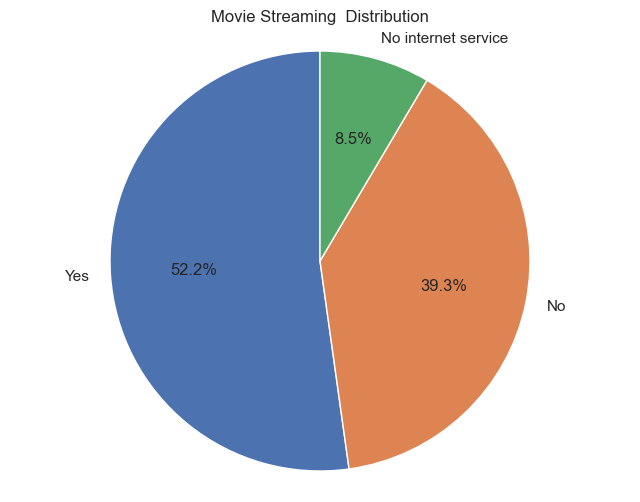

In [260]:
# Set the style of the plot
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))

# Calculate the count of each category
counts = train['StreamingMovies'].value_counts()

# Create the pie chart
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title("Movie Streaming  Distribution")

# Show the plot
plt.show()

##### Contract

In [261]:
train['Contract'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

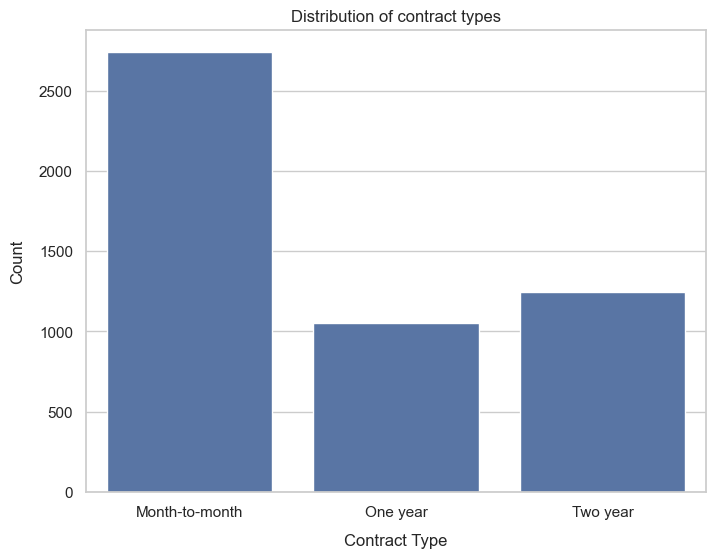

In [262]:
# Set the style of the plot
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))  
# Create the horizontal bar plot
sns.countplot(x='Contract', data=train)
plt.xlabel("Contract Type", labelpad=10)
plt.ylabel("Count", labelpad=10)
plt.title("Distribution of contract types", y=1)

# Show the plot
plt.show()

##### PaperlessBilling

In [263]:
train['PaperlessBilling'].unique()

array([True, False, 'Yes', 'No'], dtype=object)

In [264]:
# Change all entries under PaperlessBilling to 'Yes' or 'No'
replacement_values = {True: 'Yes', False:'No'}

train['PaperlessBilling'] = train['PaperlessBilling'].replace(replacement_values)

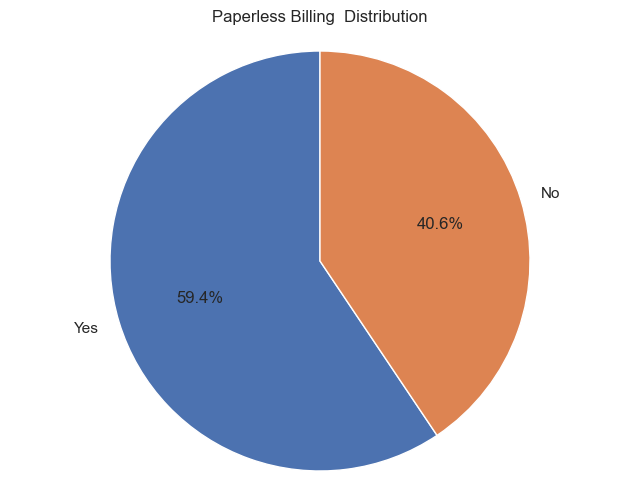

In [265]:
# Set the style of the plot
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))

# Calculate the count of each category
counts = train['PaperlessBilling'].value_counts()

# Create the pie chart
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title("Paperless Billing  Distribution")

# Show the plot
plt.show()

##### PaymentMethod 

In [266]:
train['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

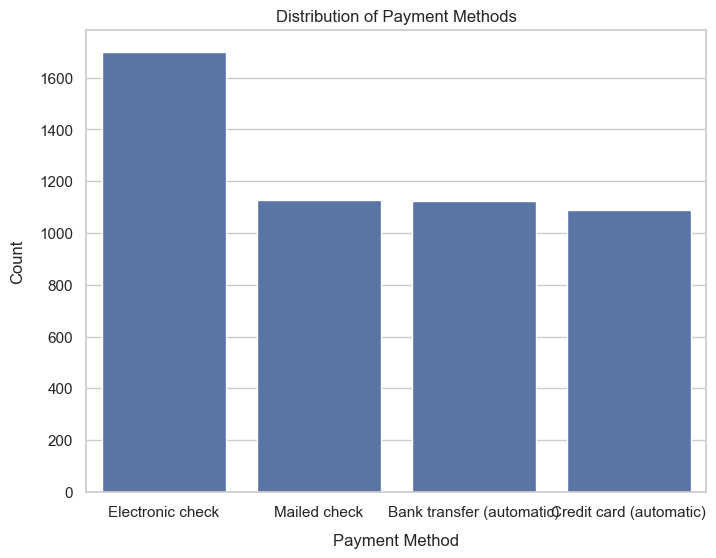

In [267]:
# Set the style of the plot
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))  
# Create the horizontal bar plot
sns.countplot(x='PaymentMethod', data=train)
plt.xlabel("Payment Method", labelpad=10)
plt.ylabel("Count", labelpad=10)
plt.title("Distribution of Payment Methods", y=1)

# Show the plot
plt.show()

##### MonthlyCharges 

In [268]:
train['MonthlyCharges']

0        29.850000
1        56.950001
2        53.849998
3        42.299999
4        70.699997
           ...    
2038     84.800000
2039    103.200000
2040     29.600000
2041     74.400000
2042    105.650000
Name: MonthlyCharges, Length: 5043, dtype: float64

In [269]:
train['MonthlyCharges'].max()

118.6500015258789

In [270]:
train['MonthlyCharges'].min()

18.399999618530277

In [271]:
# Group the monthly charges in bins of 20
labels = ["{0} - {1}".format(i, i + 19) for i in range(1, 119, 20)]

train['MonthlyCharges_range'] = pd.cut(train.MonthlyCharges, range(1, 120, 19), right=False, labels=labels)

# Counts of each monthly charge range
train['MonthlyCharges_range'].value_counts()


MonthlyCharges_range
81 - 100     1267
61 - 80       947
21 - 40       852
101 - 120     815
41 - 60       691
1 - 20        429
Name: count, dtype: int64

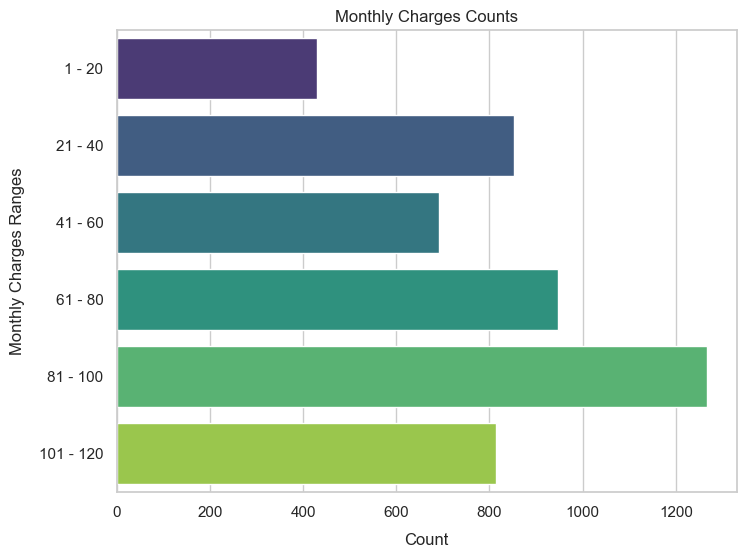

In [272]:
MonthlyCharges_counts = train['MonthlyCharges_range'].value_counts().reset_index()

# Set the style of the plot
sns.set(style="whitegrid")

# Create a count plot for tenure ranges
plt.figure(figsize=(8, 6))
sns.barplot(x='count', y='MonthlyCharges_range', data=MonthlyCharges_counts, palette="viridis")

# Labeling and title
plt.xlabel("Count", labelpad=10)
plt.ylabel("Monthly Charges Ranges", labelpad=10)
plt.title("Monthly Charges Counts", y=1)

# Show the plot
plt.show()


##### TotalCharges 

In [273]:
train['TotalCharges']

0            29.85
1           1889.5
2       108.150002
3          1840.75
4       151.649994
           ...    
2038        1990.5
2039        7362.9
2040        346.45
2041         306.6
2042        6844.5
Name: TotalCharges, Length: 5043, dtype: object

In [274]:
train['TotalCharges'].dtype

dtype('O')

In [275]:
train['TotalCharges'].isna().sum()

0

In [276]:
train['TotalCharges'].str.count(" ").sum()

3.0

In [277]:
train['TotalCharges'] = train['TotalCharges'].replace(" ", 0)

In [278]:
train['TotalCharges'] = train['TotalCharges'].astype(float)

In [279]:
train['TotalCharges'].dtype

dtype('float64')

##### Churn

In [280]:
# Check for unique values
train['Churn'].unique()

array([False, True, 'No', 'Yes'], dtype=object)

In [281]:
# Change all entries under churn to 'Yes' or 'No'
replacement_values = {False: 'No', True: 'Yes'}

train['Churn'] = train['Churn'].replace(replacement_values)

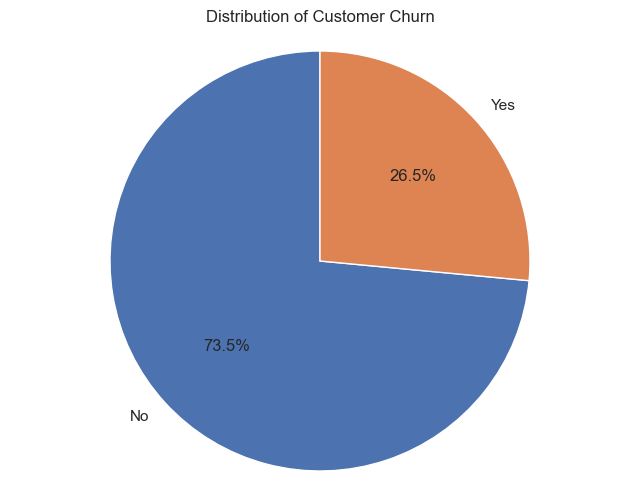

In [282]:
# Set the style of the plot
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))

# Calculate the count of each category
counts = train['Churn'].value_counts()

# Create the pie chart
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title("Distribution of Customer Churn")

# Show the plot
plt.show()

The churn rate is 26.5%

In [283]:
train.to_csv("Cleaned Datasets/training_dataset.csv")

In [284]:
train['tenure_range'].value_counts()

tenure_range
1 - 12     1534
61 - 72    1017
13 - 24     732
25 - 36     603
49 - 60     590
37 - 48     559
Name: count, dtype: int64

## Questions and Answers

### Univariate Analysis 

### 1. Does the gender of the customer affect the churn rate?


In [285]:
# Grouping the data by 'gender' and 'churn' and calculating the counts
grouped_data = train.groupby(['gender', 'Churn']).size().reset_index(name='count')

In [286]:
# Creating the grouped bar chart
fig = px.bar(grouped_data, x='gender', y='count', color='Churn', barmode='group')

# Customizing the chart layout
fig.update_layout(
    title="Distribution of Churn by Gender",
    xaxis_title="Gender",
    yaxis_title="Count",
    legend_title="Churn",
)

# Displaying the chart
fig.show()

938 females churned and 954 males churned. It is hard to tell if the gender of the customer affects the churn rate as the difference is not so significant

### 2. Are senior citizens more reluctant to churn than those who are not senior citizens?

In [287]:
# Grouping the data by 'SeniorCitizen' and 'Churn' and calculating the counts
grouped_data = train.groupby(['SeniorCitizen', 'Churn']).size().reset_index(name='count')

In [288]:
# Creating the grouped bar chart 
fig = px.bar(grouped_data, x='SeniorCitizen', y='count', color='Churn', barmode='group')

# Customizing the x-axis labels
fig.update_xaxes(
    ticktext=['No', 'Yes'],
    tickvals=[0, 1]
)
# Customizing the chart layout
fig.update_layout(
    title="Distribution of Churn by Senior Citizens",
    xaxis_title="Senior Citizen",
    yaxis_title="Count",
    legend_title="Churn",
)

# Displaying the chart
fig.show()

Per the distribution, those that are not senior citizens are more likely to churn

### 3. How does the amount spent per month affect churn?

For this distribution, we would have to look at segmentation of the monthly charges

In [289]:
# Grouping the data by 'MonthlyCharges_range' and 'Churn' and calculating the counts
grouped_data = train.groupby(['MonthlyCharges_range', 'Churn']).size().reset_index(name='count')

In [290]:
# Creating the grouped bar chart
fig = px.bar(grouped_data, x='MonthlyCharges_range', y='count', color='Churn', barmode='group')

# Customizing the chart layout
fig.update_layout(
    title="Distribution of Churn by Range of Monthly Charges",
    xaxis_title="Monthly Charge Range",
    yaxis_title="Count",
    legend_title="Churn",
)

# Displaying the chart
fig.show()

Customers that spend between 80 to 101 dollars monthly are more likely to churn than any other group

### 4. How important is tech support in customer retention?

In [291]:
# Grouping the data by 'TechSupport' and 'Churn' and calculating the counts
grouped_data = train.groupby(['TechSupport', 'Churn']).size().reset_index(name='count')


In [292]:
# Creating the grouped bar chart 
fig = px.bar(grouped_data, x='TechSupport', y='count', color='Churn', barmode='group')

# Customizing the chart layout
fig.update_layout(
    title="Tech Support and Customer Retention",
    xaxis_title="Tech Support?",
    yaxis_title="Count",
    legend_title="Churn",
)

# Displaying the chart
fig.show()

5,576 had internet service. Out of this number, 3,467 did not opt for tech support and 2,109 customers opted for tech support. Comparing this with churn, customers who chose not to go for tech support were more likely(1448 customers) to churn than those who subscribed for tech support(331 customers). With the difference in the sum of yes and no responses being close, it means tech support is important for customer retention

### 5. Does internet service subscription affect the payment method used?

In [293]:
# Grouping the data by 'MonthlyCharges_range' and 'Churn' and calculating the counts
grouped_data = train.groupby(['InternetService', 'PaymentMethod']).size().reset_index(name='count')

In [294]:
# Creating the grouped bar chart 
fig = px.bar(grouped_data, x='InternetService', y='count', color='PaymentMethod', barmode='group')

# Customizing the chart layout
fig.update_layout(
    title="Internet Service Subscription and Payment Methods",
    xaxis_title="Internet Service",
    yaxis_title="Count",
    legend_title="Payment Methods",
)

# Displaying the chart
fig.show()

### 6. What tenure range is very likely to churn? 

In [295]:
# Grouping the data by 'MonthlyCharges_range' and 'Churn' and calculating the counts
grouped_data = train.groupby(['tenure_range', 'Churn']).size().reset_index(name='count')

In [296]:
# Creating the grouped bar chart 
fig = px.bar(grouped_data, x='tenure_range', y='count', color='Churn', barmode='group')

# Customizing the chart layout
fig.update_layout(
    title="Churners accirding Tenure range",
    xaxis_title="Tenure Range",
    yaxis_title="Count",
    legend_title="Churn",
)

# Displaying the chart
fig.show()

The company is most likely to lose a customer in the first 12 months of the customer's tenure than at any other time

### Bivariate and Multivariate Analysis

### 7. Does having a partner and dependents influence churn rate positively or negatively?

In [297]:
# Filter the data for customers who answered 'Yes' under 'Partner' and 'Yes' under 'Dependents'
filtered_data = train[(train['Partner'] == 'Yes') & (train['Dependents'] == 'Yes')]


In [298]:
# Group the filtered data by 'Churn' and calculate the count
grouped_data = filtered_data.groupby('Churn').size().reset_index(name='Count')


In [299]:
# Create the bar chart using Plotly Express
fig = px.bar(grouped_data, x='Churn', y='Count', color='Churn',
             labels={'Count': 'Count', 'Churn': 'Churn'})

# Set the layout of the plot
fig.update_layout(
    title="Churn Distribution among Customers with Partners and Dependents",
    xaxis_title="Churn",
    yaxis_title="Count",
    legend_title="Churn"
)

# Show the plot
fig.show()

In [300]:
# Filter the data for customers who answered 'No' under 'Partner' and 'No' under 'Dependents'
filtered_data = train[(train['Partner'] == 'No') & (train['Dependents'] == 'No')]

In [301]:
# Group the filtered data by 'Churn' and calculate the count
grouped_data = filtered_data.groupby('Churn').size().reset_index(name='Count')

In [302]:
# Create the bar chart using Plotly Express
fig = px.bar(grouped_data, x='Churn', y='Count', color='Churn',
             labels={'Count': 'Count', 'Churn': 'Churn'})

# Set the layout of the plot
fig.update_layout(
    title="Churn Distribution among Customers without Partners and Dependents",
    xaxis_title="Churn",
    yaxis_title="Count",
    legend_title="Churn"
)

# Show the plot
fig.show()

Churn rate of customers with partners and dependents was 14% while churn rate of customers without partners and dependents was 34%

### 8. Do customers with both phone service and internet service churn more than customers with one of the two?

In [303]:
# Filter the data for customers who answered Yes' under 'PhoneService' and'Yes' under 'InternetService' 
filtered_data = train[(train['PhoneService'] == 'Yes') &  (train['InternetService'] == 'Yes')]
filtered_data

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_range,MonthlyCharges_range
1,Male,No,No,No,34,Yes,No,Yes,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950001,1889.500000,No,25 - 36,41 - 60
2,Male,No,No,No,2,Yes,No,Yes,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.849998,108.150002,Yes,1 - 12,41 - 60
4,Female,No,No,No,2,Yes,No,Yes,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.699997,151.649994,Yes,1 - 12,61 - 80
5,Female,No,No,No,8,Yes,Yes,Yes,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.650002,820.500000,Yes,1 - 12,101 - 120
6,Male,No,No,Yes,22,Yes,Yes,Yes,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.099998,1949.400024,No,13 - 24,81 - 100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2035,Male,No,No,No,19,Yes,No,Yes,No,No,No,No,Yes,No,Month-to-month,Yes,Bank transfer (automatic),78.700000,1495.100000,No,13 - 24,81 - 100
2038,Male,No,Yes,Yes,24,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.800000,1990.500000,No,13 - 24,81 - 100
2039,Female,No,Yes,Yes,72,Yes,Yes,Yes,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.200000,7362.900000,No,61 - 72,101 - 120
2041,Male,Yes,Yes,No,4,Yes,Yes,Yes,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.400000,306.600000,Yes,1 - 12,61 - 80


In [304]:
# Calculate churn rate for customers with phone service or internet service
churn_rate = filtered_data['Churn'].value_counts() / len(filtered_data) * 100

In [305]:
# Plotting the churn rate
fig = px.bar(churn_rate, x=churn_rate.index, y=churn_rate.values,color ='count', 
             labels={'x': 'Churn', 'y': 'Churn Rate (%)'},
             title='Churn Rate of Customers with Phone and Internet Service')
fig.show()

In [306]:
# Filter customers with phone service or internet service
has_phone_or_internet = train[(train['InternetService'] == 'Yes') | (train['PhoneService'] == 'Yes')]


In [307]:
# Calculate churn rate for customers with phone service or internet service
churn_rate = has_phone_or_internet['Churn'].value_counts() / len(has_phone_or_internet) * 100

In [308]:
# Plotting the churn rate
fig = px.bar(churn_rate, x=churn_rate.index, y=churn_rate.values,color ='count', 
             labels={'x': 'Churn', 'y': 'Churn Rate (%)'},
             title='Churn Rate of Customers with Phone or Internet Service')
fig.show()

Churn rate for customers with both Phone and Internet service is about 32.9% and Churn rate for customers with either Phone or Internet Service is 26.7%

### 9. What is the distribution of the churn rates of customers that have both internet service and online security against those that have internet service and no online security?

In [309]:
# Filter customers with internet service and online security
filtered_data1 = train[(train['InternetService'] == 'Yes') & (train['OnlineSecurity'] == 'Yes')]

# Filter customers with internet service and no online security
filtered_data2 = train[(train['InternetService'] == 'Yes') & (train['OnlineSecurity'] == 'No')]

In [310]:
# Calculate churn rate for customers with internet service and online security
churn_rate1 = filtered_data1['Churn'].value_counts() / len(filtered_data1) * 100
churn_rate1

Churn
No     85.302198
Yes    14.697802
Name: count, dtype: float64

In [311]:
churn_rate2 = filtered_data2['Churn'].value_counts() / len(filtered_data2) * 100
churn_rate2

Churn
No     58.276825
Yes    41.723175
Name: count, dtype: float64

In [312]:

# Create a figure with two subplots
fig = px.bar(churn_rate1, x=churn_rate1.index, y=churn_rate1.values,color='count',
             labels={'x': 'Churn', 'y': 'Churn Rate (%)'},
             title='Churn Rate of Customers with Internet Service and Online Security')

fig.add_trace(px.bar(churn_rate2, x=churn_rate2.index, y=churn_rate2.values,color='count',
                     labels={'x': 'Churn', 'y': 'Churn Rate (%)'},
                     title='Churn Rate of Customers with Internet Service and No Online Security').data[0])

# Update layout to show subplots side by side
fig.update_layout(barmode='group')

fig.show()


Customers with internet service and online security had a churn rate of 14.9% whereas customers with internet service and no online security had a churn rate of 41.7%

## Hypothesis Testing

In [313]:
# Filter customers that have month to month contracts
month = (train['Contract'] == 'Month-to-month')
month.head()

# Filter customers that have contracts that are one year and two year
year = (train['Contract'] == 'One year') & (train['Contract'] == 'Two year')
year.head()

0    False
1    False
2    False
3    False
4    False
Name: Contract, dtype: bool

In [314]:
# Calculate churn rate for customers with month to month contracts
# churn_month = month['Churn'].value_counts() / len(month) * 100
# churn_month

churn_month = month.value_counts() / len(month) * 100
churn_month


Contract
True     54.412056
False    45.587944
Name: count, dtype: float64

In [315]:
# Calculate churn rate for customers with yearly contracts
churn_year = year.value_counts() / len(year) * 100
churn_year


Contract
False    100.0
Name: count, dtype: float64

In [316]:
# # Create a figure with two subplots
fig = px.bar(churn_month, x=churn_month.index, y=churn_month.values,
             labels={'x': 'Churn', 'y': 'Churn Rate (%)'},
             title='Churn Rate of Customers with Month to Month Contracts against Customers with Year to Year Contracts')

fig.add_trace(px.bar(churn_year, x=churn_year.index, y=churn_year.values,
                     labels={'x': 'Churn', 'y': 'Churn Rate (%)'},
                     title='Churn Rate of Customers with Yearly Contracts').data[0])

# Update layout to show subplots side by side
fig.update_layout(barmode='group')

fig.show()



### Customers on the Month to Month contract type had a higher churn rate than customers on the One Year or Two Year Contracts and so we reject the Null Hypothesis 

In [317]:
# make all column names lowercase in training dataset
train.columns = map(str.lower, train.columns)
train.columns

Index(['gender', 'seniorcitizen', 'partner', 'dependents', 'tenure',
       'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity',
       'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv',
       'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod',
       'monthlycharges', 'totalcharges', 'churn', 'tenure_range',
       'monthlycharges_range'],
      dtype='object')

In [318]:
# make all column names lowercase in test dataset
test.columns = map(str.lower, test.columns)
test.columns

Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'tenure', 'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges'],
      dtype='object')

In [319]:
# Save datasets
train.to_csv('Cleaned Datasets/training_dataset.csv')
test.to_csv('Cleaned Datasets/testing_dataset.csv')

### Bivariate Analysis

### Violin Plot for Comparing Churn (Yes/No) vrs Monthly charges

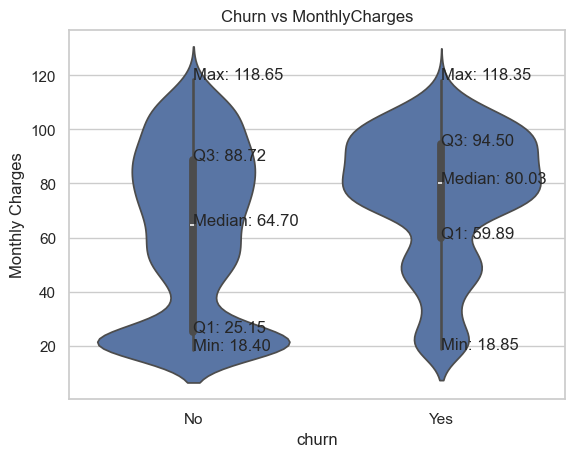

In [320]:
# Create a violin plot
ax = sns.violinplot(x='churn', y='monthlycharges', data=train)

# Add title and y-label
ax.set_title('Churn vs MonthlyCharges')
ax.set_ylabel('Monthly Charges')

# Add statistical values for the spread
for i, category in enumerate(train['churn'].unique()):
    data = train[train['churn'] == category]['monthlycharges']
    q1 = data.quantile(0.25)
    median = data.median()
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    upper_whisker = data[data <= (q3 + 1.5*iqr)].max()
    lower_whisker = data[data >= (q1 - 1.5*iqr)].min()
    ax.text(i, upper_whisker, f"Max: {upper_whisker:.2f}")
    ax.text(i, q3, f"Q3: {q3:.2f}")
    ax.text(i, median, f"Median: {median:.2f}")
    ax.text(i, q1, f"Q1: {q1:.2f}")
    ax.text(i, lower_whisker, f"Min: {lower_whisker:.2f}")

# Set legend and show plot
#ax.legend(labels=['No Churn', 'Churn'])
plt.show()

### Monthly Charges vs. Total Charges (Correlation Analysis)

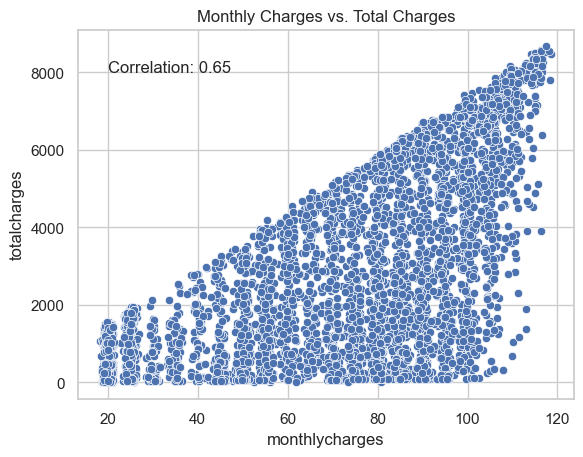

In [321]:
# Calculate correlation between MonthlyCharges and TotalCharges
corr = np.corrcoef(train['monthlycharges'], train['totalcharges'])[0, 1]

# Create scatter plot
sns.scatterplot(x='monthlycharges', y='totalcharges', data=train)
plt.title('Monthly Charges vs. Total Charges')

# Add correlation value to the plot
plt.text(20, 8000, f'Correlation: {corr:.2f}')

plt.show()

### Tenure vs. Total Charges (Correlation Analysis)

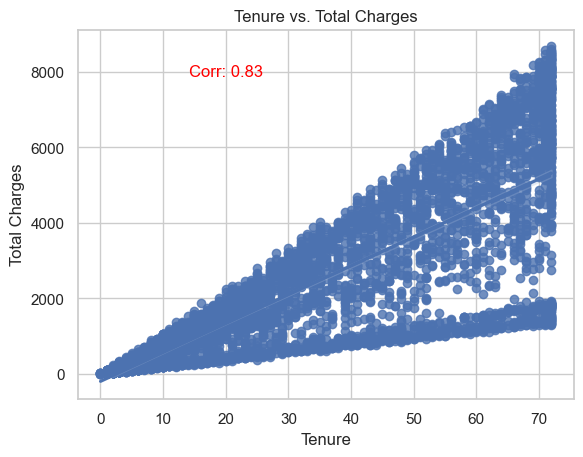

In [322]:
sns.regplot(x='tenure', y='totalcharges', data=train)
plt.title("Tenure vs. Total Charges")
plt.xlabel("Tenure")
plt.ylabel("Total Charges")

# Calculate correlation coefficient
corr = train['tenure'].corr(train['totalcharges'])
corr_text = f'Corr: {corr:.2f}'

# Add correlation value to the plot
plt.text(20, 8000, corr_text, ha='center', va='center', color='red')

plt.show()

### BoxPlot Analysis: Monthly Charges Vrs all Categorical Variables

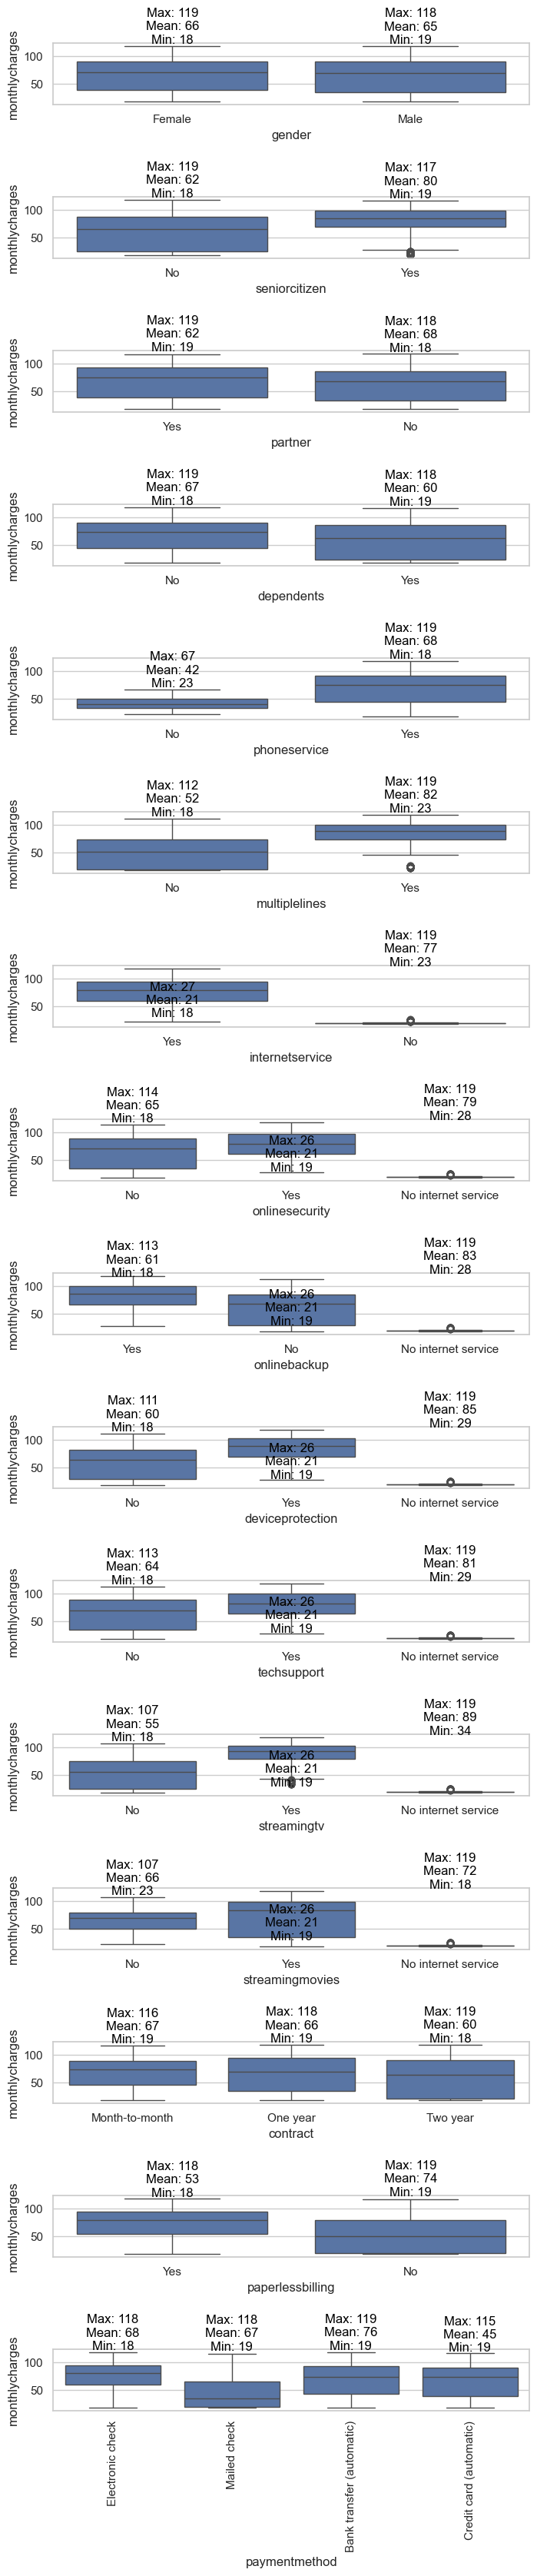

In [323]:
# Create a list of all categorical columns except Churn
cat_cols = train.select_dtypes(include=['object']).columns.drop(['churn'])

# Set up the subplots
fig, axes = plt.subplots(nrows=len(cat_cols), ncols=1, figsize=(8, 40))
plt.subplots_adjust(wspace=1.5, hspace=1.5)

# Loop through each categorical column and create a box plot with monthlycharges
for i, col in enumerate(cat_cols):
    sns.boxplot(x=col, y='monthlycharges', data=train, ax=axes[i])
    axes[i].set_xlabel(col)
    
    # Add mean, max, and min to the plot
    stats_df = train.groupby(col).agg({'monthlycharges': ['mean', 'max', 'min']})
    for idx, label in enumerate(stats_df.index):
        axes[i].text(idx, stats_df.loc[label, ('monthlycharges', 'max')], 
                      f"Max: {stats_df.loc[label, ('monthlycharges', 'max')]:.0f}\n"
                      f"Mean: {stats_df.loc[label, ('monthlycharges', 'mean')]:.0f}\n"
                      f"Min: {stats_df.loc[label, ('monthlycharges', 'min')]:.0f}", 
                      ha='center', va='bottom', color='black')
    
plt.xticks(rotation=90)
    
# Display the plot
plt.show()

### BoxPlot Analysis: Tenure Vrs all Categorical Variables

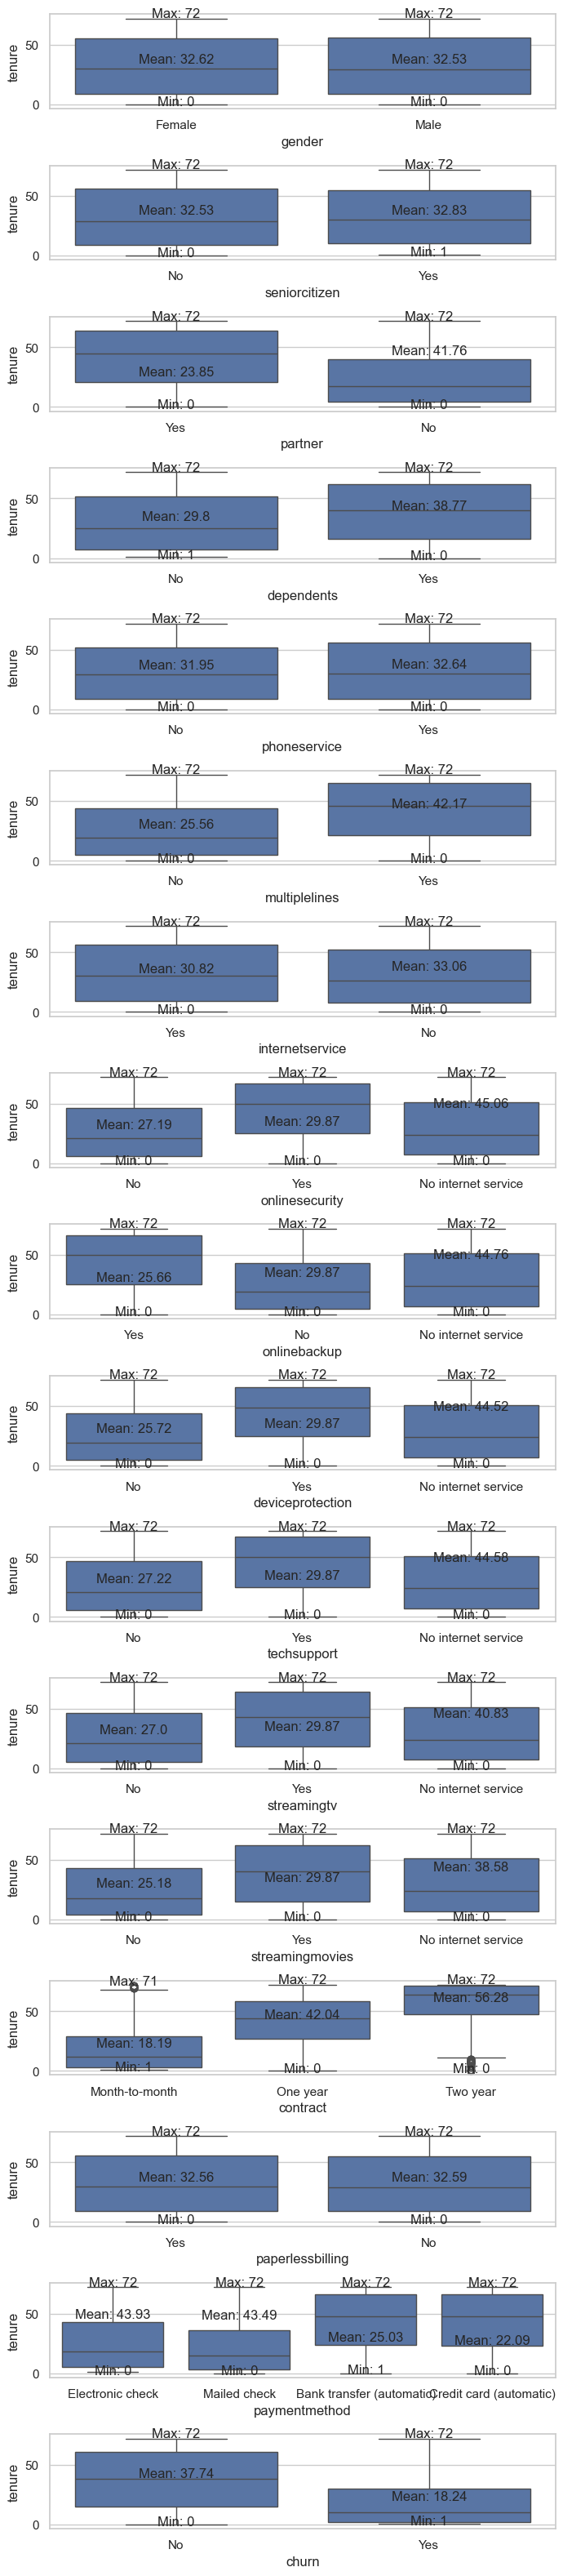

In [324]:
# Create a list of all categorical columns
cat_cols = list(train.select_dtypes(include=['object']).columns)

# Set up the subplots
fig, axes = plt.subplots(nrows=len(cat_cols), ncols=1, figsize=(8, 40))
plt.subplots_adjust(wspace=0.6, hspace=0.6)

# Loop through each categorical column and create a box plot with tenure
for i, col in enumerate(cat_cols):
    sns.boxplot(x=col, y='tenure', data=train, ax=axes[i])
    axes[i].set_xlabel(col)
    
    # Add statistical values to the plot
    mean = round(train.groupby(col)['tenure'].mean(), 2)
    max_val = train.groupby(col)['tenure'].max()
    min_val = train.groupby(col)['tenure'].min()
    
    for j in range(len(mean)):
        axes[i].text(j, max_val[j]+1, f'Max: {max_val[j]}', ha='center')
        axes[i].text(j, mean[j], f'Mean: {mean[j]}', ha='center', va='bottom')
        axes[i].text(j, min_val[j]-1, f'Min: {min_val[j]}', ha='center')
    
# Display the plot
plt.show()


### BoxPlot Analysis: TotalCharges Vrs all Categorical Variables

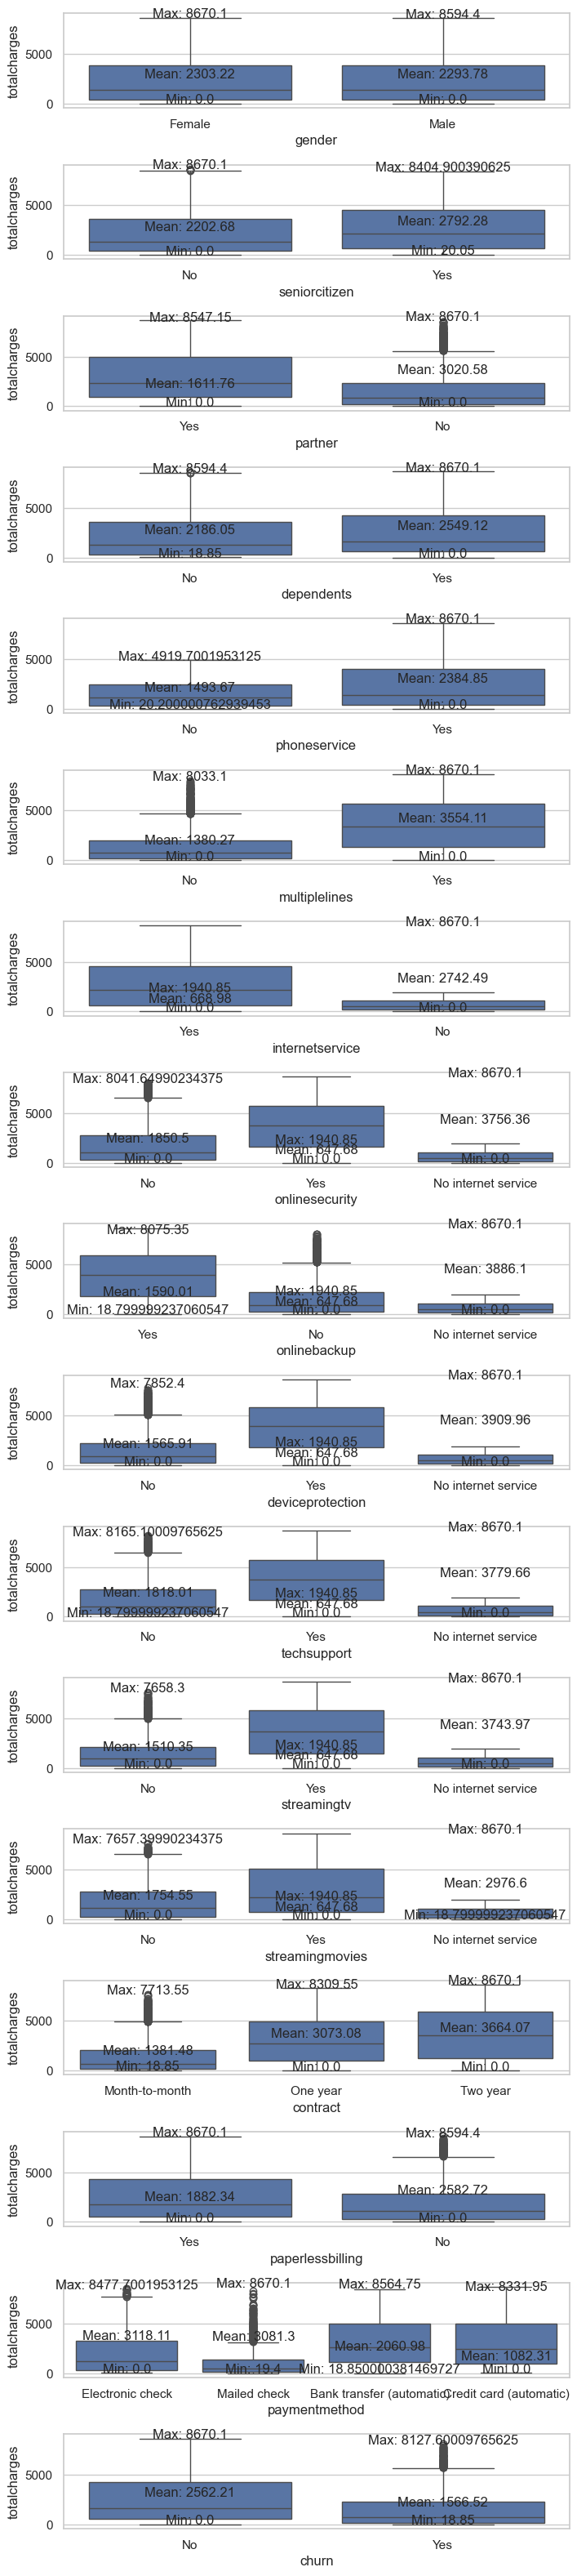

In [325]:
# Create a list of all categorical columns
cat_cols = list(train.select_dtypes(include=['object']).columns)

# Set up the subplots
fig, axes = plt.subplots(nrows=len(cat_cols), ncols=1, figsize=(8, 40))
plt.subplots_adjust(wspace=0.6, hspace=0.6)

# Loop through each categorical column and create a box plot with tenure
for i, col in enumerate(cat_cols):
    sns.boxplot(x=col, y='totalcharges', data=train, ax=axes[i])
    axes[i].set_xlabel(col)
    
    # Add statistical values to the plot
    mean = round(train.groupby(col)['totalcharges'].mean(), 2)
    max_val = train.groupby(col)['totalcharges'].max()
    min_val = train.groupby(col)['totalcharges'].min()
    
    for j in range(len(mean)):
        axes[i].text(j, max_val[j]+1, f'Max: {max_val[j]}', ha='center')
        axes[i].text(j, mean[j], f'Mean: {mean[j]}', ha='center', va='bottom')
        axes[i].text(j, min_val[j]-1, f'Min: {min_val[j]}', ha='center')
    
# Display the plot
plt.show()


### Multivariate Analaysis

### Correlation between all the numerical attributes

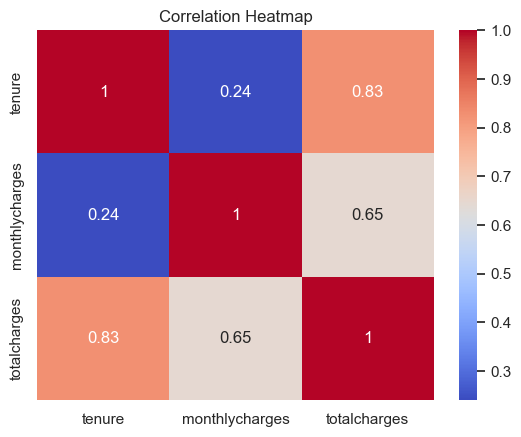

In [327]:
# Heatmap to visualize the correlation between all the numerical attributes in the dataset.
numeric_cols = ['tenure', 'monthlycharges', 'totalcharges']
corr_matrix = train[numeric_cols].corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

### Monthly charges for each combination of internet service type and contract type

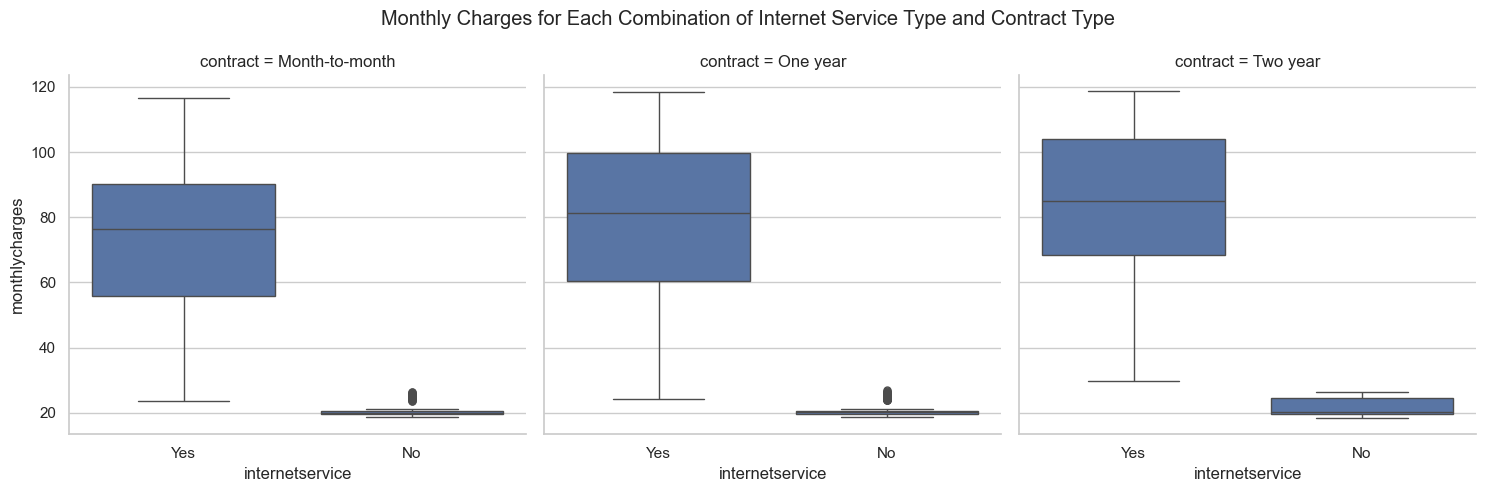

In [328]:
# Box plot of the monthly charges for each combination of internet service type and contract type.

# Filter the data for only the relevant columns
internet_contract = train[['internetservice', 'contract', 'monthlycharges']]

# Create the box plot
sns.catplot(x='internetservice', y='monthlycharges', col='contract', data=internet_contract, kind='box')

# Add plot titles and labels
plt.suptitle('Monthly Charges for Each Combination of Internet Service Type and Contract Type')
plt.subplots_adjust(top=0.85)
plt.show()

### Comparing the number of customers who churned and did not churn, grouped by internet service type and payment method

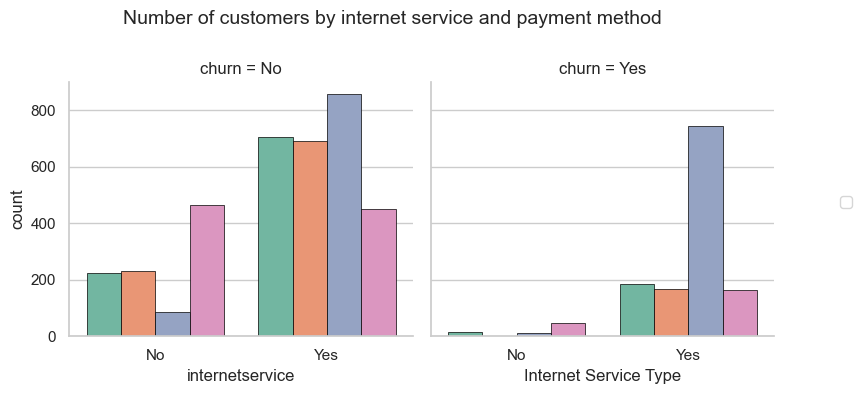

In [329]:
#Stacked bar chart to compare the number of customers who churned and did not churn, grouped by internet service type and payment method.

# Subset the data to include only relevant columns
train_sub = train[['churn', 'internetservice', 'paymentmethod']]

# Group by the variables and count the number of occurrences
churn_data_grouped = train_sub.groupby(['churn', 'internetservice', 'paymentmethod']).size().reset_index(name='count')

# Create a stacked bar chart
sns.set_style('whitegrid')
sns.set_palette('Set2')
sns.catplot(x='internetservice', y='count', hue='paymentmethod', col='churn', data=churn_data_grouped, kind='bar', height=4, aspect=1, legend=False, edgecolor='black', linewidth=0.5)

# Set the chart title and axes labels
plt.subplots_adjust(top=0.8)
plt.suptitle('Number of customers by internet service and payment method', fontsize=14)
plt.xlabel('Internet Service Type', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)

# Add a legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.gcf().legend(handles, labels, bbox_to_anchor=(1.05, 0.5), loc='center left')

## Machine Learning Modelling

### Data Loading

In [330]:
#Load train and test datasets
train_data= pd.read_csv("Cleaned Datasets/training_dataset.csv")
test_data = pd.read_csv("Cleaned Datasets/testing_dataset.csv")

#### Exploring train dataset

In [331]:
train_data

,Unnamed: 0,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn,tenure_range,monthlycharges_range
0,0,Female,No,Yes,No,1,No,No,Yes,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.850000,No,1 - 12,21 - 40
1,1,Male,No,No,No,34,Yes,No,Yes,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950001,1889.500000,No,25 - 36,41 - 60
2,2,Male,No,No,No,2,Yes,No,Yes,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.849998,108.150002,Yes,1 - 12,41 - 60
3,3,Male,No,No,No,45,No,No,Yes,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.299999,1840.750000,No,37 - 48,41 - 60
4,4,Female,No,No,No,2,Yes,No,Yes,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.699997,151.649994,Yes,1 - 12,61 - 80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5038,2038,Male,No,Yes,Yes,24,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.800000,1990.500000,No,13 - 24,81 - 100
5039,2039,Female,No,Yes,Yes,72,Yes,Yes,Yes,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.200000,7362.900000,No,61 - 72,101 - 120
5040,2040,Female,No,Yes,Yes,11,No,No,Yes,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.600000,346.450000,No,1 - 12,21 - 40
5041,2041,Male,Yes,Yes,No,4,Yes,Yes,Yes,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.400000,306.600000,Yes,1 - 12,61 - 80


In [332]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            5043 non-null   int64  
 1   gender                5043 non-null   object 
 2   seniorcitizen         5043 non-null   object 
 3   partner               5043 non-null   object 
 4   dependents            5043 non-null   object 
 5   tenure                5043 non-null   int64  
 6   phoneservice          5043 non-null   object 
 7   multiplelines         5043 non-null   object 
 8   internetservice       5043 non-null   object 
 9   onlinesecurity        5043 non-null   object 
 10  onlinebackup          5043 non-null   object 
 11  deviceprotection      5043 non-null   object 
 12  techsupport           5043 non-null   object 
 13  streamingtv           5043 non-null   object 
 14  streamingmovies       5043 non-null   object 
 15  contract             

In [333]:
train_data = train_data.drop(["Unnamed: 0"], axis=1)
train_data

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn,tenure_range,monthlycharges_range
0,Female,No,Yes,No,1,No,No,Yes,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.850000,No,1 - 12,21 - 40
1,Male,No,No,No,34,Yes,No,Yes,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950001,1889.500000,No,25 - 36,41 - 60
2,Male,No,No,No,2,Yes,No,Yes,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.849998,108.150002,Yes,1 - 12,41 - 60
3,Male,No,No,No,45,No,No,Yes,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.299999,1840.750000,No,37 - 48,41 - 60
4,Female,No,No,No,2,Yes,No,Yes,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.699997,151.649994,Yes,1 - 12,61 - 80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5038,Male,No,Yes,Yes,24,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.800000,1990.500000,No,13 - 24,81 - 100
5039,Female,No,Yes,Yes,72,Yes,Yes,Yes,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.200000,7362.900000,No,61 - 72,101 - 120
5040,Female,No,Yes,Yes,11,No,No,Yes,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.600000,346.450000,No,1 - 12,21 - 40
5041,Male,Yes,Yes,No,4,Yes,Yes,Yes,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.400000,306.600000,Yes,1 - 12,61 - 80


In [334]:
train_data = train_data.drop(["tenure_range", "monthlycharges_range"], axis=1)
train_data

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,Female,No,Yes,No,1,No,No,Yes,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.850000,No
1,Male,No,No,No,34,Yes,No,Yes,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950001,1889.500000,No
2,Male,No,No,No,2,Yes,No,Yes,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.849998,108.150002,Yes
3,Male,No,No,No,45,No,No,Yes,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.299999,1840.750000,No
4,Female,No,No,No,2,Yes,No,Yes,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.699997,151.649994,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5038,Male,No,Yes,Yes,24,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.800000,1990.500000,No
5039,Female,No,Yes,Yes,72,Yes,Yes,Yes,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.200000,7362.900000,No
5040,Female,No,Yes,Yes,11,No,No,Yes,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.600000,346.450000,No
5041,Male,Yes,Yes,No,4,Yes,Yes,Yes,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.400000,306.600000,Yes


In [335]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5043 non-null   object 
 1   seniorcitizen     5043 non-null   object 
 2   partner           5043 non-null   object 
 3   dependents        5043 non-null   object 
 4   tenure            5043 non-null   int64  
 5   phoneservice      5043 non-null   object 
 6   multiplelines     5043 non-null   object 
 7   internetservice   5043 non-null   object 
 8   onlinesecurity    5043 non-null   object 
 9   onlinebackup      5043 non-null   object 
 10  deviceprotection  5043 non-null   object 
 11  techsupport       5043 non-null   object 
 12  streamingtv       5043 non-null   object 
 13  streamingmovies   5043 non-null   object 
 14  contract          5043 non-null   object 
 15  paperlessbilling  5043 non-null   object 
 16  paymentmethod     5043 non-null   object 


In [336]:
# Count the number of samples in each class
class_counts = train_data['churn'].value_counts()

# Calculate the class proportions
class_proportions = class_counts / len(train_data)

print("Class Distribution:")
print(class_counts)

print("\nClass Proportions:")
print(class_proportions)

Class Distribution:
churn
No     3707
Yes    1336
Name: count, dtype: int64

Class Proportions:
churn
No     0.735078
Yes    0.264922
Name: count, dtype: float64


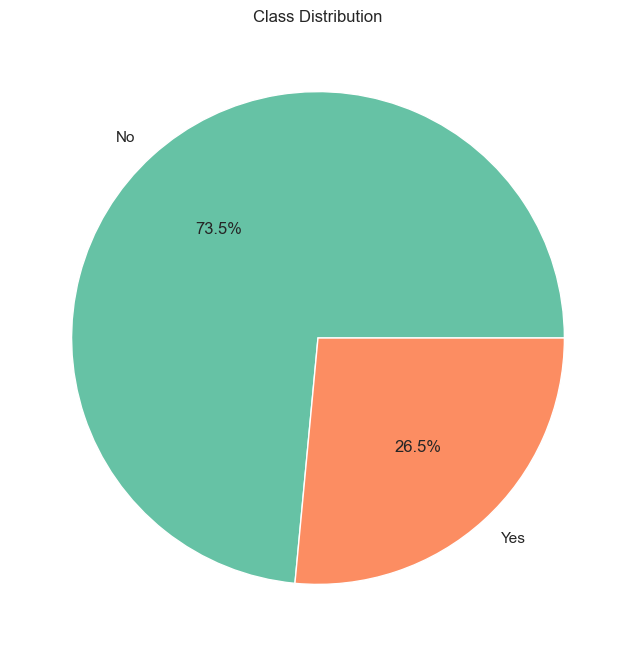

In [337]:
# Count the number of samples in each class
class_counts = train_data['churn'].value_counts()

# Get the class labels and their counts
labels = class_counts.index
counts = class_counts.values

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.title('Class Distribution')
plt.show()

In [338]:
train_data.describe()

,tenure,monthlycharges,totalcharges
count,5043.000000,5043.000000,5043.000000
mean,32.576641,65.090214,2298.430994
std,24.529807,30.068133,2269.512503
min,0.000000,18.400000,0.000000
25%,9.000000,35.775000,415.724997
50%,29.000000,70.550003,1398.599976
75%,56.000000,90.050003,3857.575073
max,72.000000,118.650002,8670.100000


### Exploring test dataset

In [339]:
test_data

,Unnamed: 0,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges
0,0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8
2,2,9513-DXHDA,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55
3,3,2640-PMGFL,Male,0,No,Yes,27,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55
4,4,3801-HMYNL,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1995,7912-SYRQT,Female,0,No,No,7,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),75.10,552.95
1996,1996,3557-HTYWR,Female,0,No,No,47,Yes,Yes,DSL,Yes,Yes,No,Yes,No,Yes,Two year,No,Mailed check,74.05,3496.3
1997,1997,4816-JBHOV,Male,1,No,No,2,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,44.70,93.7
1998,1998,8920-NAVAY,Male,1,No,No,62,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),110.75,7053.35


In [340]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        2000 non-null   int64  
 1   customerid        2000 non-null   object 
 2   gender            2000 non-null   object 
 3   seniorcitizen     2000 non-null   int64  
 4   partner           2000 non-null   object 
 5   dependents        2000 non-null   object 
 6   tenure            2000 non-null   int64  
 7   phoneservice      2000 non-null   object 
 8   multiplelines     2000 non-null   object 
 9   internetservice   2000 non-null   object 
 10  onlinesecurity    2000 non-null   object 
 11  onlinebackup      2000 non-null   object 
 12  deviceprotection  2000 non-null   object 
 13  techsupport       2000 non-null   object 
 14  streamingtv       2000 non-null   object 
 15  streamingmovies   2000 non-null   object 
 16  contract          2000 non-null   object 


In [341]:
empty_strings = test_data[test_data["totalcharges"] == ' ']
empty_strings

,Unnamed: 0,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges
331,331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,
826,826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,
1380,1380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,


In [342]:
# Convert empty strings to NaN
test_data["totalcharges"] = test_data["totalcharges"].replace(' ', np.nan)

# Convert the column to float
test_data["totalcharges"] = test_data["totalcharges"].astype(float)

# Calculate the column mean
mean_total_charges = test_data["totalcharges"].mean()

# Impute NaN values with the mean
test_data["totalcharges"].fillna(mean_total_charges, inplace=True)


In [343]:
is_dash_present = "-" in test_data.values
is_dash_present

False

In [344]:
is_empty_present = " " in test_data.values
is_empty_present

False

In [345]:
test_data = test_data.drop(["customerid"], axis=1 )
test_data

,Unnamed: 0,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges
0,0,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,1,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.80
2,2,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55
3,3,Male,0,No,Yes,27,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55
4,4,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1995,Female,0,No,No,7,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),75.10,552.95
1996,1996,Female,0,No,No,47,Yes,Yes,DSL,Yes,Yes,No,Yes,No,Yes,Two year,No,Mailed check,74.05,3496.30
1997,1997,Male,1,No,No,2,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,44.70,93.70
1998,1998,Male,1,No,No,62,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),110.75,7053.35


In [346]:
# make all column names lowercase
test_data.columns = map(str.lower, test_data.columns)
test_data

,unnamed: 0,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges
0,0,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,1,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.80
2,2,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55
3,3,Male,0,No,Yes,27,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55
4,4,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1995,Female,0,No,No,7,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),75.10,552.95
1996,1996,Female,0,No,No,47,Yes,Yes,DSL,Yes,Yes,No,Yes,No,Yes,Two year,No,Mailed check,74.05,3496.30
1997,1997,Male,1,No,No,2,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,44.70,93.70
1998,1998,Male,1,No,No,62,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),110.75,7053.35


In [347]:
test_data.describe()

,unnamed: 0,seniorcitizen,tenure,monthlycharges,totalcharges
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,999.500000,0.161500,31.853000,63.933325,2235.995093
std,577.494589,0.368084,24.632677,30.136858,2258.097978
min,0.000000,0.000000,0.000000,18.250000,18.900000
25%,499.750000,0.000000,8.000000,34.250000,354.812500
50%,999.500000,0.000000,27.000000,69.800000,1389.475000
75%,1499.250000,0.000000,55.000000,89.275000,3626.262500
max,1999.000000,1.000000,72.000000,118.750000,8684.800000


In [348]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   unnamed: 0        2000 non-null   int64  
 1   gender            2000 non-null   object 
 2   seniorcitizen     2000 non-null   int64  
 3   partner           2000 non-null   object 
 4   dependents        2000 non-null   object 
 5   tenure            2000 non-null   int64  
 6   phoneservice      2000 non-null   object 
 7   multiplelines     2000 non-null   object 
 8   internetservice   2000 non-null   object 
 9   onlinesecurity    2000 non-null   object 
 10  onlinebackup      2000 non-null   object 
 11  deviceprotection  2000 non-null   object 
 12  techsupport       2000 non-null   object 
 13  streamingtv       2000 non-null   object 
 14  streamingmovies   2000 non-null   object 
 15  contract          2000 non-null   object 
 16  paperlessbilling  2000 non-null   object 


In [349]:
train_data.isna().sum()

gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

In [350]:
#Converting our target variable "churn" to binary numeric values to represent Yes and No

# Create a NumPy array to represent the target variable
target = np.where(train_data['churn'] == 'Yes', 1, 0)

# Assign the new NumPy array to the 'churn' column
train_data['churn'] = target

# Verify the conversion
train_data['churn'].unique 

<bound method Series.unique of 0       0
1       0
2       1
3       0
4       1
       ..
5038    0
5039    0
5040    0
5041    1
5042    0
Name: churn, Length: 5043, dtype: int32>

In [351]:
categorical = ['gender','seniorcitizen','partner','dependents','phoneservice','multiplelines', 
               'internetservice','onlinesecurity','onlinebackup','deviceprotection','techsupport',
               'streamingtv','streamingmovies', 'contract','paperlessbilling','paymentmethod']

In [352]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

### Split the Data into Training and Testing Sets

In [353]:
# Split the data into features (X) and target variable (y)
X = train_data.drop('churn', axis=1)
y = train_data['churn']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shape of the train and test sets
print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Train set shape: (4034, 19) (4034,)
Test set shape: (1009, 19) (1009,)


### New Features Creation

In [354]:
# Calculate the ratio of monthly charges to total charges for train data
X_train['MonthlyCharges_TotalCharges_Ratio'] = X_train['monthlycharges'] / X_train['totalcharges']

# Calculate the ratio of monthly charges to total charges for test data
X_test['MonthlyCharges_TotalCharges_Ratio'] = X_test['monthlycharges'] / X_test['totalcharges']

In [355]:
# Calculating the average monthly charges

X_train['AverageMonthlyCharges'] = np.where(X_train['tenure'] != 0, (X_train['totalcharges'] / X_train['tenure']).round(2), 0)

X_test['AverageMonthlyCharges'] = np.where(X_test['tenure'] != 0, (X_test['totalcharges'] / X_test['tenure']).round(2), 0)

In [356]:
# Append the new feature to the numerical list
numerical+=('MonthlyCharges_TotalCharges_Ratio','AverageMonthlyCharges')

This indicate whether the customer consistently pays their monthly charges or has any outstanding balance. This feature captures patterns or correlations between the payment behavior and the likelihood of churn.

AverageMonthlyCharges is useful because it captures the average amount the customer pays per month during their tenure.

In [357]:
# Checking for infinite values
is_infinite = X_train[numerical].isin([np.inf, -np.inf])

# Summing up infinite values for each column
infinite_counts = is_infinite.sum()

# Display columns with infinite values
columns_with_infinity = infinite_counts[infinite_counts > 0].index
print("Columns with Infinite values:", columns_with_infinity)

# Display rows with infinite values
rows_with_infinity = X_train[numerical][X_train[numerical].isin([np.inf, -np.inf]).any(axis=1)]
print("Rows with Infinite values:", rows_with_infinity)

Columns with Infinite values: Index(['MonthlyCharges_TotalCharges_Ratio'], dtype='object')
Rows with Infinite values:       tenure  monthlycharges  totalcharges  MonthlyCharges_TotalCharges_Ratio  \
4670       0           73.35           0.0                                inf   
3218       0           19.70           0.0                                inf   
4754       0           61.90           0.0                                inf   

      AverageMonthlyCharges  
4670                    0.0  
3218                    0.0  
4754                    0.0  


Since the rows are only 3, we can drop them

In [358]:
# Dropping rows with infinity values
indices_to_remove = [4670, 3218, 4754]  # Replace with your actual row indices

# Drop rows by index
X_train.drop(indices_to_remove, inplace=True)

In [359]:
# Drop corresponding rows from y_train
y_train.drop(indices_to_remove, inplace=True)

y_train.reset_index(drop=True, inplace=True)


#### Feature Encoding (on Training and Test Data)

In [360]:
# Apply one-hot encoding on the training set
encoder = OneHotEncoder(drop='if_binary')
X_train_encoded = pd.DataFrame(encoder.fit_transform(X_train[categorical]).toarray(),
                               columns=encoder.get_feature_names_out(categorical),
                               index=X_train.index)

# Apply the same encoding on the testing set
X_test_encoded = pd.DataFrame(encoder.transform(X_test[categorical]).toarray(),
                              columns=encoder.get_feature_names_out(categorical),
                              index=X_test.index)


### Feature scaling

In [361]:
# Reindex the DataFrame
X_train.reset_index(drop=True, inplace=True)


In [362]:
# Create an instance of the StandardScaler
scaler = StandardScaler()

# Fit and transform the numeric variables in the training set
X_train_encoded[numerical] = scaler.fit_transform(X_train[numerical])

# Transform the numeric variables in the testing set using the fitted scaler
X_test_encoded[numerical] = scaler.transform(X_test[numerical])

In [363]:
X_train_encoded

,gender_Male,seniorcitizen_Yes,partner_Yes,dependents_Yes,phoneservice_Yes,multiplelines_Yes,internetservice_Yes,onlinesecurity_No,onlinesecurity_No internet service,onlinesecurity_Yes,onlinebackup_No,onlinebackup_No internet service,onlinebackup_Yes,deviceprotection_No,deviceprotection_No internet service,deviceprotection_Yes,techsupport_No,techsupport_No internet service,techsupport_Yes,streamingtv_No,streamingtv_No internet service,streamingtv_Yes,streamingmovies_No,streamingmovies_No internet service,streamingmovies_Yes,contract_Month-to-month,contract_One year,contract_Two year,paperlessbilling_Yes,paymentmethod_Bank transfer (automatic),paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,tenure,monthlycharges,totalcharges,MonthlyCharges_TotalCharges_Ratio,AverageMonthlyCharges
463,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-1.047126,1.151991,-0.716892,-0.026909,1.028163
3688,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.345634,-1.489923,-0.625161,-0.463864,-1.432737
1270,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.246832,-1.335976,-0.316638,-0.488502,-1.316476
2118,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.432673,0.501445,-0.220644,-0.387172,0.541055
594,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.292907,-0.642391,-0.995637,2.938603,-0.637687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4426,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.345634,-0.495067,-0.114768,-0.457130,-0.509570
466,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.287796,1.228137,1.887899,-0.488643,1.225114
3092,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.047126,-1.475025,-0.948939,-0.070711,-1.430102
3772,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.492613,0.561037,1.471746,-0.492073,0.534139


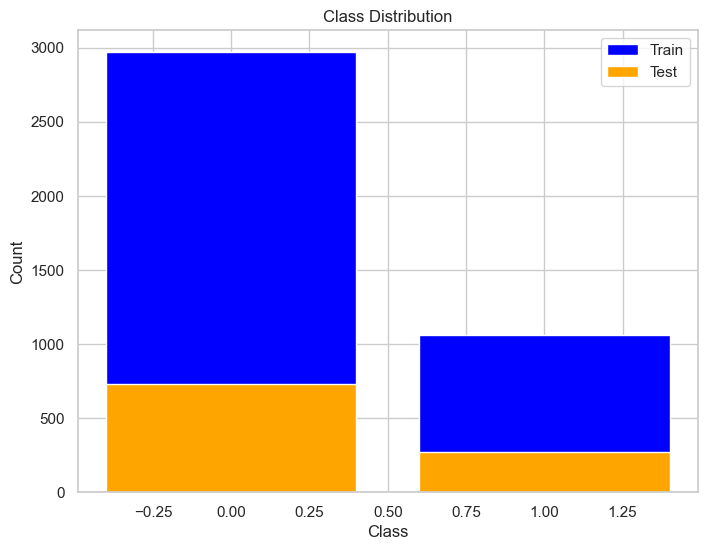

In [364]:
# Convert y_train and y_test to Pandas Series
y_train_series = pd.Series(y_train)
y_test_series = pd.Series(y_test)

# Count the number of samples in each class in the training set
train_class_counts = y_train_series.value_counts()

# Count the number of samples in each class in the testing set
test_class_counts = y_test_series.value_counts()

plt.figure(figsize=(8, 6))
plt.bar(train_class_counts.index, train_class_counts.values, color='blue', label='Train')
plt.bar(test_class_counts.index, test_class_counts.values, color='orange', label='Test')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.legend()
plt.show()

In [365]:
train_churn_count = pd.Series(y_train).value_counts()
test_churn_count = pd.Series(y_test).value_counts()

print("Churn count in y_train:")
print(train_churn_count)

print("\nChurn count in y_test:")
print(test_churn_count)

Churn count in y_train:
churn
0    2970
1    1061
Name: count, dtype: int64

Churn count in y_test:
churn
0    734
1    275
Name: count, dtype: int64


In [366]:
smote_tomek = SMOTETomek()

# Apply SMOTETomek to the training data
X_train_balanced, y_train_balanced = smote_tomek.fit_resample(X_train_encoded, y_train)

# Check the count of each class in the balanced training data
balanced_class_count = pd.Series(y_train_balanced).value_counts()
print("Class count in the balanced training data:")
print(balanced_class_count)

Class count in the balanced training data:
churn
1    2895
0    2895
Name: count, dtype: int64


#### Train Models / Evaluate / Model Comparison

In [367]:
# Define the calculate_metrics function
def calculate_metrics(y_true, y_pred):
    metrics = {}
    metrics['f1_score'] = f1_score(y_true, y_pred)
    return metrics

In [368]:
# Initialize the models
models = [
    LogisticRegression(random_state=4, solver='liblinear', max_iter=1000),
    DecisionTreeClassifier(random_state=4, criterion='gini', min_samples_leaf=8, max_depth=5),
    RandomForestClassifier(random_state=4, n_estimators=100, max_depth=5),
    GradientBoostingClassifier(random_state=4, n_estimators=100, learning_rate=0.1),
    AdaBoostClassifier(random_state=4, n_estimators=100, learning_rate=0.1),
    SVC(random_state=4, kernel='rbf', C=1.0),
    KNeighborsClassifier(n_neighbors=5),
    GaussianNB(),
    XGBClassifier(random_state=4, n_estimators=100, learning_rate=0.1),
    LGBMClassifier(random_state=4, n_estimators=100, learning_rate=0.1),
    CatBoostClassifier(random_state=4, verbose=0, iterations=100)
]

model_names = [
    'Logistic Regression',
    'Decision Tree',
    'Random Forest',
    'Gradient Boosting',
    'AdaBoost',
    'SVM',
    'KNN',
    'Naive Bayes',
    'XGBoost',
    'LightGBM',
    'CatBoost'
]


In [369]:
leaderboard_imbalanced = {}

for model, name in zip(models, model_names):
    model.fit(X_train_encoded,y_train)
    y_pred = model.predict(X_test_encoded)
    metrics = calculate_metrics(y_test, y_pred)
    leaderboard_imbalanced[name] = metrics
    
    # Print the classification report
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred, labels=[0, 1], target_names=['No', 'Yes']))
    print()

# Create a DataFrame from the leaderboard dictionary
leaderboard_df = pd.DataFrame(leaderboard_imbalanced).transpose()

# Format the F1-score column to display with two decimal places
leaderboard_df['Imbalanced Data F1-score'] = leaderboard_df['f1_score'].map('{:.2f}'.format)

leaderboard_df.sort_values(by='Imbalanced Data F1-score', ascending=False, inplace=True)


leaderboard_df.index.name = 'Models'
leaderboard_df.reset_index(inplace=True)

print("Leaderboard: Imbalanced Data")
leaderboard_df.drop('f1_score', axis=1, inplace=True)
leaderboard_df

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

          No       0.84      0.91      0.88       734
         Yes       0.69      0.55      0.62       275

    accuracy                           0.81      1009
   macro avg       0.77      0.73      0.75      1009
weighted avg       0.80      0.81      0.80      1009


Classification Report for Decision Tree:
              precision    recall  f1-score   support

          No       0.82      0.91      0.86       734
         Yes       0.65      0.46      0.54       275

    accuracy                           0.78      1009
   macro avg       0.73      0.68      0.70      1009
weighted avg       0.77      0.78      0.77      1009


Classification Report for Random Forest:
              precision    recall  f1-score   support

          No       0.82      0.93      0.87       734
         Yes       0.69      0.44      0.54       275

    accuracy                           0.79      10

Classification Report for SVM:
              precision    recall  f1-score   support

          No       0.84      0.92      0.88       734
         Yes       0.72      0.52      0.60       275

    accuracy                           0.81      1009
   macro avg       0.78      0.72      0.74      1009
weighted avg       0.80      0.81      0.80      1009


Classification Report for KNN:
              precision    recall  f1-score   support

          No       0.83      0.86      0.84       734
         Yes       0.58      0.52      0.55       275

    accuracy                           0.77      1009
   macro avg       0.70      0.69      0.69      1009
weighted avg       0.76      0.77      0.76      1009


Classification Report for Naive Bayes:
              precision    recall  f1-score   support

          No       0.93      0.63      0.75       734
         Yes       0.47      0.88      0.61       275

    accuracy                           0.70      1009
   macro avg       0.70  

,Models,Imbalanced Data F1-score
0,Logistic Regression,0.62
1,Naive Bayes,0.61
2,XGBoost,0.61
3,SVM,0.60
4,CatBoost,0.60
5,Gradient Boosting,0.59
6,LightGBM,0.59
7,AdaBoost,0.56
8,KNN,0.55
9,Decision Tree,0.54


In [370]:
leaderboard_balanced = {}

for model, name in zip(models, model_names):
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test_encoded)
    metrics = calculate_metrics(y_test, y_pred)
    leaderboard_balanced[name] = metrics
    
    # Print the classification report
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred, labels=[0, 1], target_names=['No', 'Yes']))
    print()

# Create a DataFrame from the leaderboard dictionary
leaderboard_df1 = pd.DataFrame(leaderboard_balanced).transpose()

 #Format the F1-score column to display with two decimal places
leaderboard_df1['Balanced Data F1-score'] = leaderboard_df1['f1_score'].map('{:.2f}'.format)

# Sort the DataFrame by F1-score in descending order
leaderboard_df1.sort_values(by='Balanced Data F1-score', ascending=False, inplace=True)


leaderboard_df1.index.name = 'Models'
leaderboard_df1.reset_index(inplace=True)

print("Leaderboard: Balanced Data")
leaderboard_df1.drop('f1_score', axis=1, inplace=True)
leaderboard_df1

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

          No       0.91      0.74      0.82       734
         Yes       0.54      0.80      0.64       275

    accuracy                           0.76      1009
   macro avg       0.72      0.77      0.73      1009
weighted avg       0.81      0.76      0.77      1009


Classification Report for Decision Tree:
              precision    recall  f1-score   support

          No       0.88      0.76      0.82       734
         Yes       0.54      0.73      0.62       275

    accuracy                           0.75      1009
   macro avg       0.71      0.75      0.72      1009
weighted avg       0.79      0.75      0.76      1009


Classification Report for Random Forest:
              precision    recall  f1-score   support

          No       0.90      0.76      0.82       734
         Yes       0.55      0.78      0.64       275

    accuracy                           0.77      10

,Models,Balanced Data F1-score
0,SVM,0.66
1,Gradient Boosting,0.65
2,AdaBoost,0.65
3,Logistic Regression,0.64
4,Random Forest,0.64
5,XGBoost,0.64
6,Decision Tree,0.62
7,LightGBM,0.62
8,CatBoost,0.62
9,Naive Bayes,0.61


#### Confusion Matrix

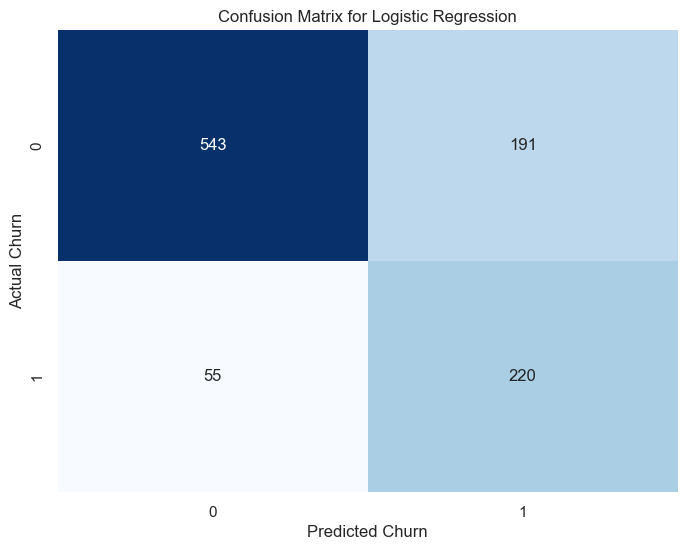

Confusion Matrix for Logistic Regression:
[[543 191]
 [ 55 220]]



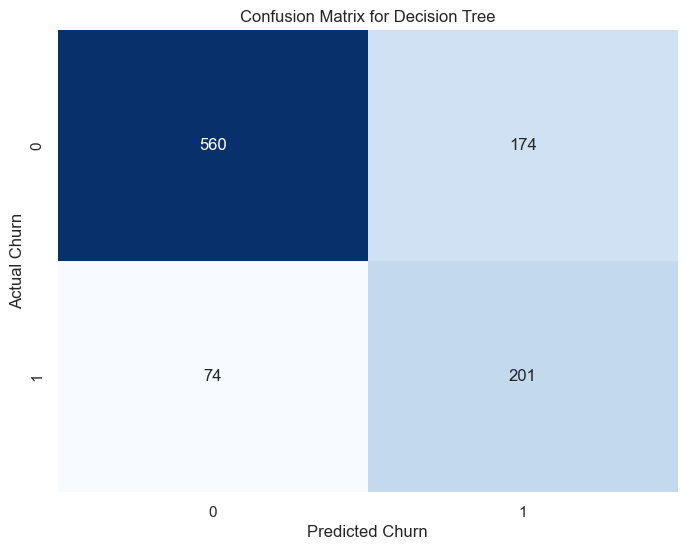

Confusion Matrix for Decision Tree:
[[560 174]
 [ 74 201]]



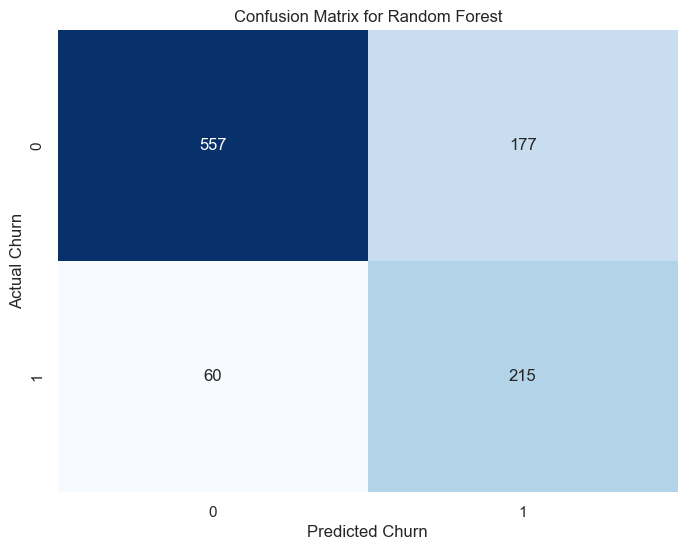

Confusion Matrix for Random Forest:
[[557 177]
 [ 60 215]]



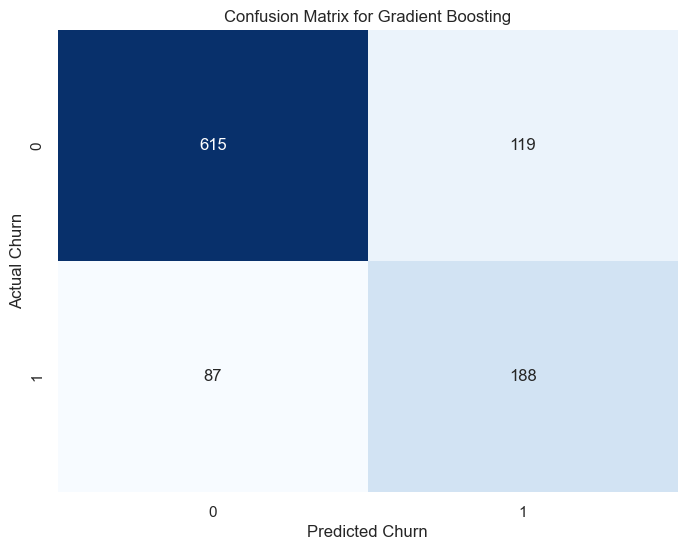

Confusion Matrix for Gradient Boosting:
[[615 119]
 [ 87 188]]



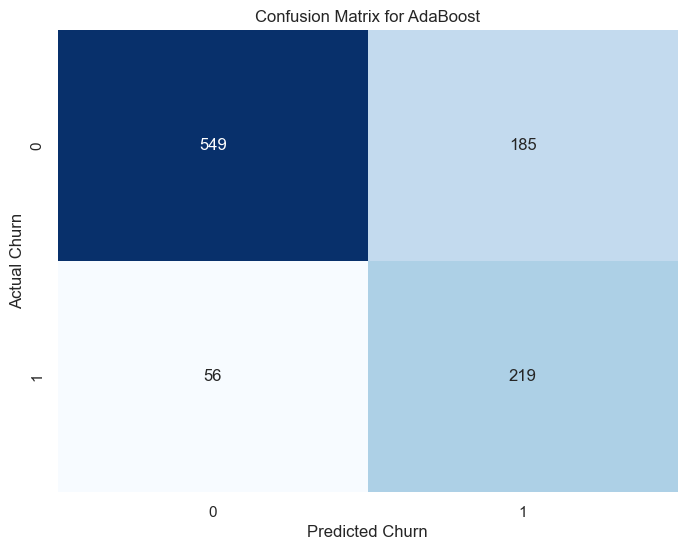

Confusion Matrix for AdaBoost:
[[549 185]
 [ 56 219]]



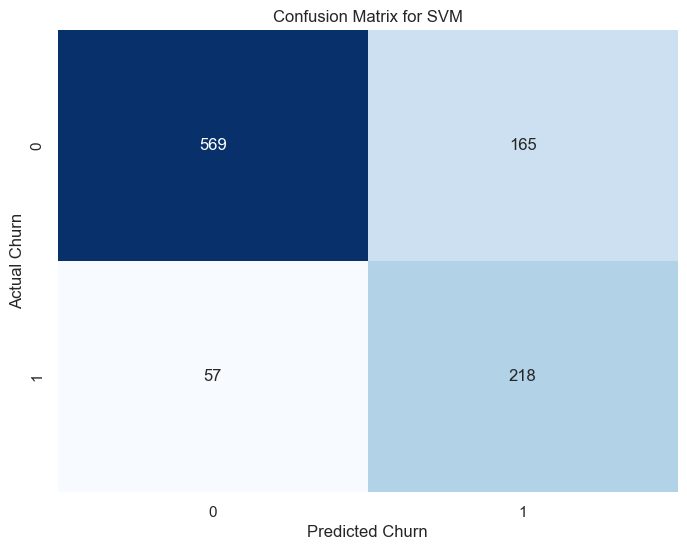

Confusion Matrix for SVM:
[[569 165]
 [ 57 218]]



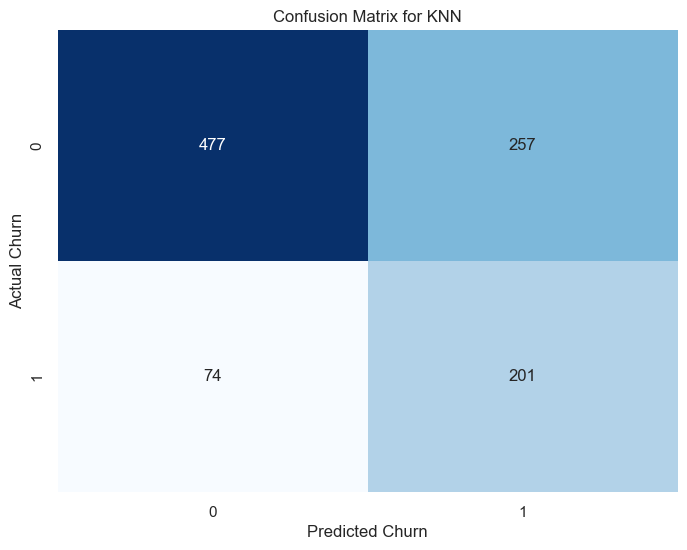

Confusion Matrix for KNN:
[[477 257]
 [ 74 201]]



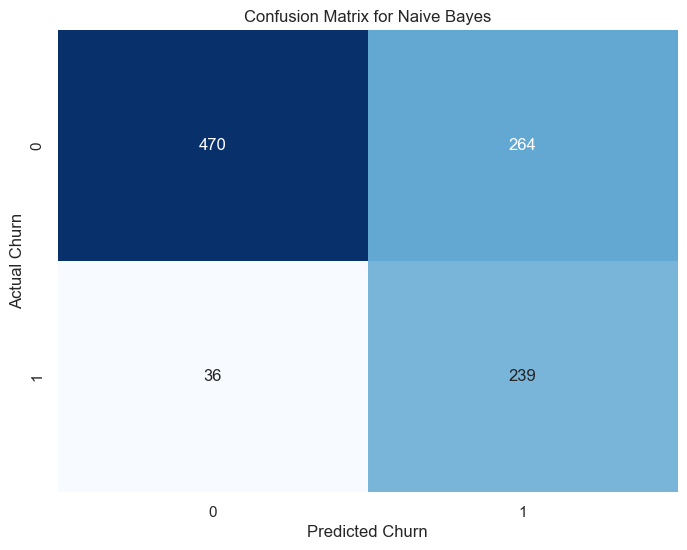

Confusion Matrix for Naive Bayes:
[[470 264]
 [ 36 239]]



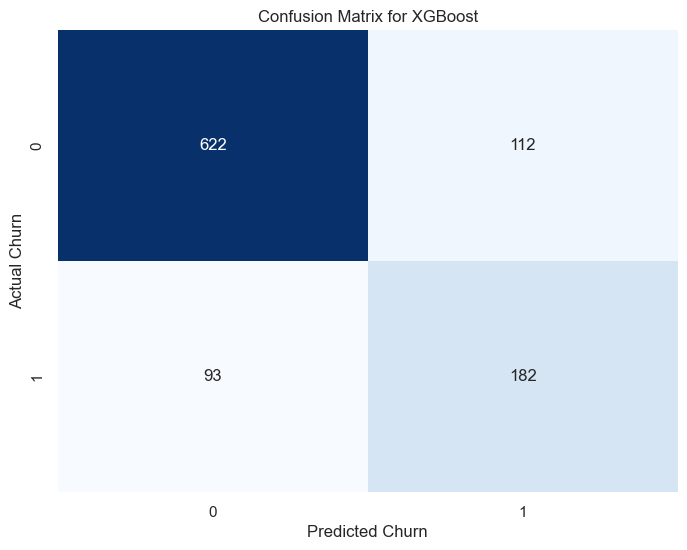

Confusion Matrix for XGBoost:
[[622 112]
 [ 93 182]]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2895, number of negative: 2895
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3665
[LightGBM] [Info] Number of data points in the train set: 5790, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


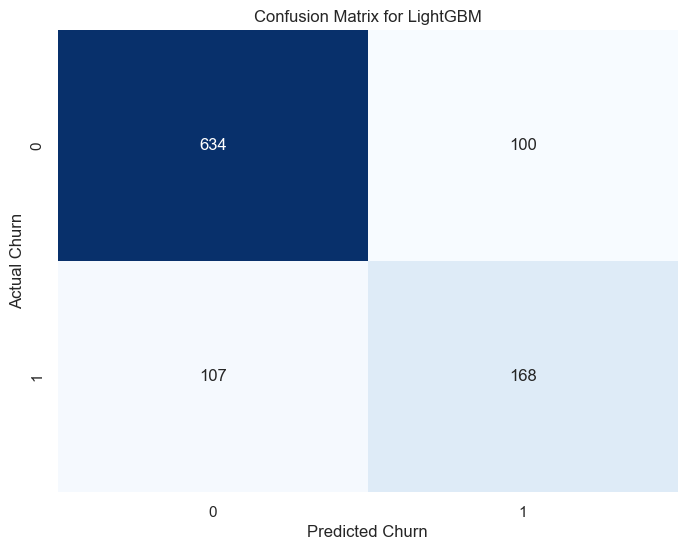

Confusion Matrix for LightGBM:
[[634 100]
 [107 168]]



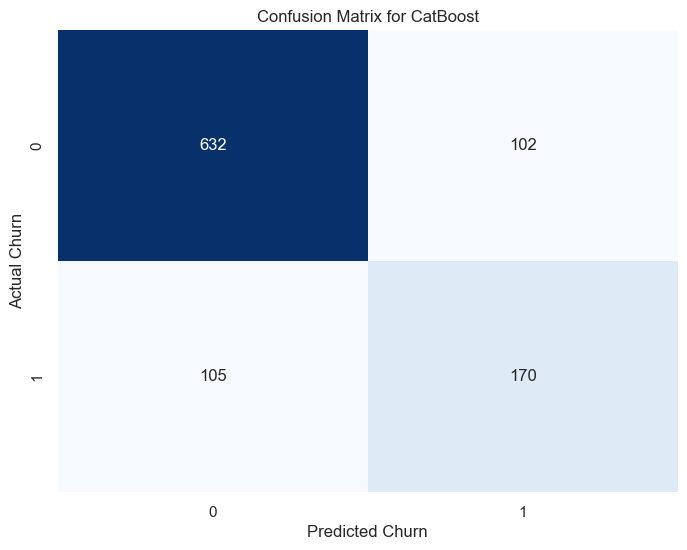

Confusion Matrix for CatBoost:
[[632 102]
 [105 170]]



In [371]:
for model, name in zip(models, model_names):
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test_encoded)
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Create a heatmap for the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel("Predicted Churn")
    plt.ylabel("Actual Churn")
    plt.show()
    
    print(f"Confusion Matrix for {name}:")
    print(cm)
    print()

### Hyperparameter Tuning

In [373]:
from sklearn.model_selection import GridSearchCV
#from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
#from sklearn.svm import SVC
#from sklearn.linear_model import LogisticRegression

# Define the top 5 models and their respective parameter grids
top_models_and_parameters = {
    'Random Forest': (RandomForestClassifier(), {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10]}),
    'SVM': (SVC(), {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}),
    'Logistic Regression': (LogisticRegression(), {'C': [0.001, 0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']}),
    'Gradient Boosting': (GradientBoostingClassifier(), {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]}),
    'AdaBoost': (AdaBoostClassifier(), {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]})
}

# Perform hyperparameter tuning for each top model on the imbalanced dataset
results_imbalanced = []
for model_name, (model, param_grid) in top_models_and_parameters.items():
    print(f"\n{model_name} - Imbalanced Dataset:")
    
    # Set up GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
    
    # Fit the grid search to the imbalanced data
    grid_search.fit(X_train_encoded, y_train)
    
    # Print the best parameters and tuned F1 score
    best_params = grid_search.best_params_
    best_f1_score = grid_search.best_score_
    print("Best Parameters:", best_params)
    print("Tuned F1 Score:", best_f1_score)
    
    # Save the results for ranking
    results_imbalanced.append({
        'Models': model_name,
        'Best Parameters': best_params,
        'Tuned F1 Score': best_f1_score
    })

# Perform hyperparameter tuning for each top model on the balanced dataset
results_balanced = []
for model_name, (model, param_grid) in top_models_and_parameters.items():
    print(f"\n{model_name} - Balanced Dataset:")
    
    # Set up GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
    
    # Fit the grid search to the balanced data
    grid_search.fit(X_train_balanced, y_train_balanced)
    
    # Print the best parameters and tuned F1 score
    best_params = grid_search.best_params_
    best_f1_score = grid_search.best_score_
    print("Best Parameters:", best_params)
    print("Tuned F1 Score:", best_f1_score)
    
    # Save the results for ranking
    results_balanced.append({
        'Models': model_name,
        'Best Parameters': best_params,
        'Tuned F1 Score': best_f1_score
    })

# Rank the models based on F1 score for both datasets
results_imbalanced_df = pd.DataFrame(results_imbalanced).sort_values(by='Tuned F1 Score', ascending=False)
results_balanced_df = pd.DataFrame(results_balanced).sort_values(by='Tuned F1 Score', ascending=False)

print("\nRanking of Models based on F1 Score - Imbalanced Dataset:")
print(results_imbalanced_df[['Models', 'Tuned F1 Score']])

print("\nRanking of Models based on F1 Score - Balanced Dataset:")
print(results_balanced_df[['Models', 'Tuned F1 Score']])



Random Forest - Imbalanced Dataset:
Best Parameters: {'max_depth': 10, 'n_estimators': 200}
Tuned F1 Score: 0.5595507683507683

SVM - Imbalanced Dataset:
Best Parameters: {'C': 0.1, 'kernel': 'linear'}
Tuned F1 Score: 0.5796404229471274

Logistic Regression - Imbalanced Dataset:
Best Parameters: {'C': 1, 'penalty': 'l2'}
Tuned F1 Score: 0.5838182541090289

Gradient Boosting - Imbalanced Dataset:
Best Parameters: {'learning_rate': 0.1, 'n_estimators': 100}
Tuned F1 Score: 0.5653017711357051

AdaBoost - Imbalanced Dataset:
Best Parameters: {'learning_rate': 0.2, 'n_estimators': 200}
Tuned F1 Score: 0.576698350772632

Random Forest - Balanced Dataset:
Best Parameters: {'max_depth': None, 'n_estimators': 200}
Tuned F1 Score: 0.87784386446812

SVM - Balanced Dataset:
Best Parameters: {'C': 10, 'kernel': 'rbf'}
Tuned F1 Score: 0.8566359008103437

Logistic Regression - Balanced Dataset:
Best Parameters: {'C': 0.1, 'penalty': 'l2'}
Tuned F1 Score: 0.8004212115841634

Gradient Boosting - Balan

In [ ]:
# Select only relevant columns for F1 scores in the tuned results
results_imbalanced_df = results_imbalanced_df[['Models', 'Tuned F1 Score']]
results_balanced_df = results_balanced_df[['Models', 'Tuned F1 Score']]

# Combine initial and tuned results for both imbalanced and balanced datasets
combined_imbalanced_df = pd.merge(leaderboard_df, results_imbalanced_df, on='Models', suffixes=('_Initial', '_Tuned'))
combined_balanced_df = pd.merge(leaderboard_df1, results_balanced_df, on='Models', suffixes=('_Initial', '_Tuned'))

# Display the combined DataFrames
print("\nCombined Results - Imbalanced Dataset:")
print(combined_imbalanced_df)

print("\nCombined Results - Balanced Dataset:")
print(combined_balanced_df)



Combined Results - Imbalanced Dataset:
                Models Imbalanced Data F1-score  Best F1 Score
0  Logistic Regression                     0.62       0.583818
1                  SVM                     0.60       0.579640
2    Gradient Boosting                     0.59       0.566336
3             AdaBoost                     0.56       0.576698
4        Random Forest                     0.54       0.563475

Combined Results - Balanced Dataset:
                Models Balanced Data F1-score  Best F1 Score
0                  SVM                   0.66       0.851503
1  Logistic Regression                   0.65       0.800318
2        Random Forest                   0.64       0.876047
3    Gradient Boosting                   0.64       0.843678
4             AdaBoost                   0.64       0.833819


Based on the hyperparameter tuning results, the Random Forest model achieved the highest score of 0.879, followed by the SVM model with a score of 0.86, and the Logistic Regression model with a score of 0.8.

Considering these results, the recommendation would be to use the Random Forest model as it demonstrated the best performance on the training data. The Random Forest model benefits from its ability to handle complex relationships in the data, reduce overfitting through ensemble learning, and provide feature importance analysis.

In [383]:
# Assigning our best performing model to a variable so we can save it
best_model = RandomForestClassifier(max_depth=None, n_estimators=200)

In [384]:
# After assigning best_model1
print(best_model)

# If it's a scikit-learn model, you can also print its parameters
print(best_model.get_params())

RandomForestClassifier(n_estimators=200)
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


#### Model Interpretation

To gain a deeper understanding of the predictions made by our best-performing model, Random Forest, we employed the Shapely Values (SHAP) technique, which allowed us to generate insightful interpretations of its decision-making process.

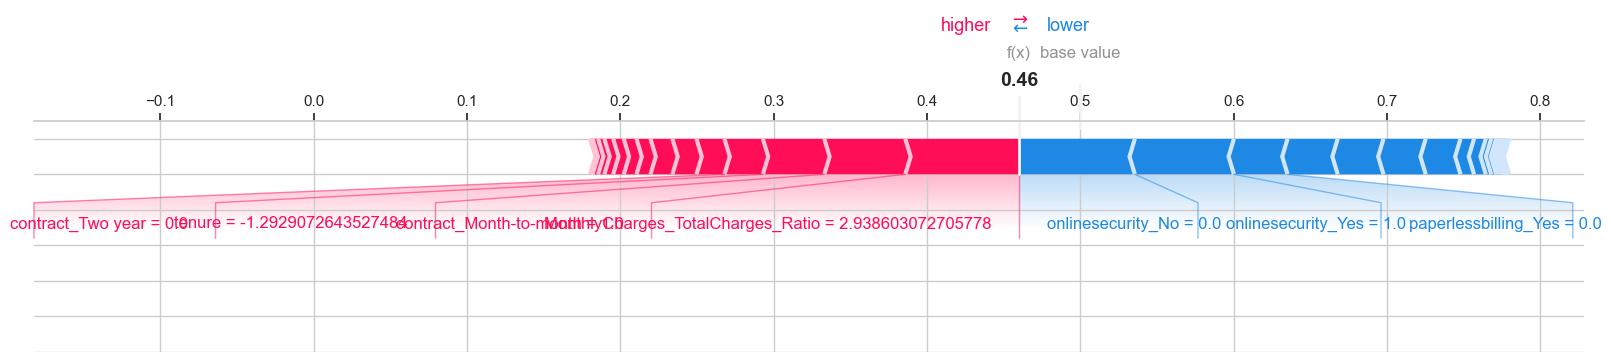

In [389]:
# Fit the model to your training data
best_model.fit(X_train_balanced, y_train_balanced)

# Create a Tree Explainer object that can calculate SHAP values
explainer = shap.TreeExplainer(best_model)

# Choose an instance for which you want to explain predictions
chosen_instance = X_test_encoded.iloc[0]

# Calculate SHAP values
shap_values = explainer.shap_values(chosen_instance)

# Plot the SHAP force plot without JavaScript (using Matplotlib)
shap.force_plot(explainer.expected_value[1], shap_values[1], chosen_instance, matplotlib=True)


Based on this interpretation, the model predicts a higher probability for class 0 (0.46). From our SHAP values and the chart produced, we can see that MonthlyCharges_TotalCharges_Ratio contributes the most to the prediction (0) made by the model. This clues the company into one of the metrics they can look at to handle their customer retention problems.

#### Saving our ML Components

In [391]:
# Create a dictionary to store the exported variables
exported_data = {
#    'categorical_imputer': categorical_imputer,
#    'numerical_imputer': numerical_imputer,
    'encoder': encoder,
    'scaler': scaler,
    'best_model': best_model
}

# Create a folder to store the exported data
folder_name = 'ML Components'
os.makedirs(folder_name, exist_ok=True)

# Export the variables
exported_data_path = os.path.join(folder_name, 'ML_Components.pkl')
with open(exported_data_path, 'wb') as file:
    pickle.dump(exported_data, file)

### Test Prediction

In [392]:
# Step 1: Load the Exported Components
ML_Components_path = 'ML Components/ML_Components.pkl'
with open(ML_Components_path, 'rb') as file:
    ML_Components = pickle.load(file)

In [393]:
encoder = ML_Components['encoder']
scaler = ML_Components['scaler']
best_model = ML_Components['best_model']

In [394]:
# Replace values in the dataframe to present a conventional output
test = test.replace({
    True: 'Yes',
    False: 'No',
    'No internet service': 'No',
    'No phone service': 'No'
}, inplace=False)

In [395]:
# Fill missing values with the most frequent values in the dataset
test = test.fillna(test.mode().iloc[0])

In [396]:
test['seniorcitizen'] = test['seniorcitizen'].map({1: 'Yes', 0: 'No'})

In [397]:
customer_ids = test['customerid'].copy()

In [398]:
test.drop('customerid', axis=1, inplace=True)

In [399]:
# Convert 'monthlycharges' column to numeric type
test['monthlycharges'] = pd.to_numeric(test['monthlycharges'], errors='coerce')

test['totalcharges'] = pd.to_numeric(test['totalcharges'], errors='coerce')

In [400]:
test['MonthlyCharges_TotalCharges_Ratio'] = test['monthlycharges'] / test['totalcharges']

test['AverageMonthlyCharges'] = np.where(test['tenure'] != 0, (test['totalcharges'] / test['tenure']).round(2), 0)

In [401]:
# Change all entries under Internet Service to 'Yes' or 'No'
replacement_values = {'Fiber optic': 'Yes', 'DSL':'Yes'}

test['internetservice'] = test['internetservice'].replace(replacement_values)

In [402]:
# Preprocessing for categorical data
test_data_categorical = test.select_dtypes(include='object')
test_data_encoded = encoder.transform(test_data_categorical)

# Convert the encoded sparse matrix to a DataFrame
test_data_encoded_df = pd.DataFrame.sparse.from_spmatrix(test_data_encoded,
                                                              columns=encoder.get_feature_names_out(test_data_categorical.columns),
                                                              index=test_data_categorical.index)

# Preprocessing for numerical data
test_data_numerical = test.select_dtypes(include=['int', 'float'])
test_data_scaled = scaler.transform(test_data_numerical)

# Convert the scaled numerical data to a DataFrame
test_data_scaled_df = pd.DataFrame(test_data_scaled,
                                         columns=test_data_numerical.columns,
                                         index=test_data_numerical.index)

# Concatenate the encoded categorical data and scaled numerical data
test_data_preprocessed = pd.concat([test_data_encoded_df, test_data_scaled_df], axis=1)

In [410]:
test_data_preprocessed.isna().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
dtype: int64

In [404]:
#test.isna().sum()

#rows_with_NaN = test.isna()
#print("Rows with NaN values:", rows_with_NaN)

# Checking for NaN values
is_NaN = test_data_preprocessed.isna()

# Summing up infinite values for each column
NaN_counts = is_NaN.sum()

# Display columns with infinite values
columns_with_NaN = NaN_counts[NaN_counts > 0].index
print("Columns with NaN values:", columns_with_NaN)

# Display rows with infinite values
rows_with_NaN = test_data_preprocessed[test_data_preprocessed.isna().any(axis=1)]
print("Rows with NaN values:", rows_with_NaN)

Columns with NaN values: Index(['totalcharges', 'MonthlyCharges_TotalCharges_Ratio'], dtype='object')
Rows with NaN values:       gender_Male  seniorcitizen_Yes  partner_Yes  dependents_Yes  \
331           1.0                0.0          1.0             1.0   
826           1.0                0.0          1.0             1.0   
1380          0.0                0.0          1.0             1.0   

      phoneservice_Yes  multiplelines_Yes  internetservice_Yes  \
331                1.0                0.0                  0.0   
826                1.0                1.0                  0.0   
1380               1.0                0.0                  0.0   

      onlinesecurity_No  onlinesecurity_No internet service  \
331                 1.0                                 0.0   
826                 1.0                                 0.0   
1380                1.0                                 0.0   

      onlinesecurity_Yes  onlinebackup_No  onlinebackup_No internet service  \
33

In [409]:
from sklearn.impute import KNNImputer

# KNN imputation
imputer = KNNImputer(n_neighbors=2)
test_data_preprocessed = pd.DataFrame(imputer.fit_transform(test_data_preprocessed))


In [411]:
test_data_preprocessed.reset_index(drop=True, inplace=True)

In [412]:
# Perform Predictions
predictions = best_model.predict(test_data_preprocessed)

In [413]:
# DataFrame for Predictions
prediction_results = pd.DataFrame({'customerID': customer_ids, 'Churn predictions': predictions})

In [414]:
# Map predictions to "Yes" and "No"
prediction_results['Churn predictions'] = prediction_results['Churn predictions'].map({1: 'Yes', 0: 'No'})

In [415]:
prediction_results

,customerID,Churn predictions
0,7613-LLQFO,Yes
1,4568-TTZRT,No
2,9513-DXHDA,No
3,2640-PMGFL,No
4,3801-HMYNL,Yes
...,...,...
1995,7912-SYRQT,Yes
1996,3557-HTYWR,No
1997,4816-JBHOV,Yes
1998,8920-NAVAY,No


In [416]:
# Count the occurrences of "Yes" and "No" in the predictions
count = prediction_results['Churn predictions'].value_counts()

# Print the count
print(count)

Churn predictions
No     1474
Yes     526
Name: count, dtype: int64


Based on the test results of predicting churn for the new test data, we observed the following:

The majority of customers (1474 out of 2000) were predicted as "No" for churn, indicating that they are less likely to churn.
A significant portion of customers (526 out of 2000) were predicted as "Yes" for churn, indicating a higher likelihood of churn.
Based on these observations, we can conclude that our model has provided predictions for customer churn. The distribution of predictions suggests that a considerable number of customers may be at risk of churn, warranting proactive retention efforts to mitigate churn and retain valuable customers.

Percentage distribution:

"No" predictions: 73.7%
"Yes" predictions: 26.3%

While the company is likely to keep majority of their customers (73.7%), the proportion that is likely to leave is quite significant and the company has to take proactive measures to retain more of their customers.
